## This is an analysis on a dataset http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008 containing patient information from 10 years across 130 hospitals. Dataset description is here https://www.hindawi.com/journals/bmri/2014/781670/tab1/

### Patients in the dataset have at least one diabetes related diagnosis. The goal is to predict if a patient will be readmitted to the hospital in under 30 days.

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns",101)
from __future__ import division
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics
 # Feature Importance
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, cross_validation
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import random
from sklearn import grid_search

sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 3})
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### There are two mapping tables and one dataset table.

In [4]:
#this table is complex because it has a number of id types
dfmap = pd.read_csv('IDS_mapping.csv') 
diag_new = pd.read_csv('cms_hcc_icd9_abbrev.csv')

In [13]:
df = pd.read_csv('diabetic_data.csv')

In [14]:
df.shape

(101766, 50)

In [6]:
#look at the data, this table actually has data which maps to three different columns in the main dataset
dfmap.head()

admission_type_id    description
0                 1      Emergency
1                 2         Urgent
2                 3       Elective
3                 4        Newborn
4                 5  Not Available

In [7]:
diag_new.head() #maps to three diagnosis code columns in the main dataset

icd9_abbrev                                      condition  n_code  \
0         003          Bone/Joint/Muscle Infections/Necrosis       2   
1         006  Pneumococcal Pneumonia, Empyema, Lung Abscess       1   
2         007                       Opportunistic Infections       1   
3         020  Pneumococcal Pneumonia, Empyema, Lung Abscess       3   
4         021  Pneumococcal Pneumonia, Empyema, Lung Abscess       1   

   max_n_code  
0           2  
1           1  
2           1  
3           3  
4           1

In [8]:
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1          ?  Pediatrics-Endocrinology                  41   
1                 3          ?                         ?                  59   
2                 2          ?                         ?                  11   
3                 2          ?                         ?                  44   
4                 1          ?                         ?                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83       ?      ?                 1          None   
1                 0     276  250.01    255                 9          None   
2                 1     648     250    V27                 6          None   
3                 0       8  250.43    403                 7          None   
4                 0     197     157    250                 5          None   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0      None        No          No          No             No          No   
1      None        No          No          No             No          No   
2      None        No          No          No             No          No   
3      None        No          No          No             No          No   
4      None        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4        

In [9]:
df.describe() #someone is on 81 medications!

encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.000000          4.000000   
75%                    4.000000             7.000000          6.000000   
max                   28.000000            25.000000         14.000000   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count       101766.000000   101766.000000    101766.000000      101766.000000   
mean            43.095641        1.339730        16.021844           0.369357   
std             19.674362        1.705807         8.127566           1.267265   
min              1.000000        0.000000         1.000000           0.000000   
25%             31.000000        0.000000        10.000000           0.000000   
50%             44.000000        1.000000        15.000000           0.000000   
75%             57.000000        2.000000        20.000000           0.000000   
max            132.000000        6.000000        81.000000          42.000000   

       number_emergency  number_inpatient  number_diagnoses  
count     101766.000000     101766.000000     101766.000000  
mean           0.197836          0.635566          7.422607  
std            0.930472          1.262863          1.933600  
min            0.000000          0.000000          1.000000  
25%            0.000000          0.000000          6.000000  
50%            0.000000          0.000000          8.000000  
75%            0.000000          1.000000          9.000000  
max           76.000000         21.000000         16.000000

### going to join and clean the data and then do some exploring before predicting

In [10]:
#separate id types to three different tables
dfadmin = dfmap[:8]
dfadmin.head()

admission_type_id    description
0                 1      Emergency
1                 2         Urgent
2                 3       Elective
3                 4        Newborn
4                 5  Not Available

In [11]:
dfdispo = dfmap[10:40]
dfdispo.columns =[['discharge_disposition_id','description']]
dfdispo.head()

discharge_disposition_id                                        description
10                        1                                 Discharged to home
11                        2  Discharged/transferred to another short term h...
12                        3                      Discharged/transferred to SNF
13                        4                      Discharged/transferred to ICF
14                        5  Discharged/transferred to another type of inpa...

In [12]:
dfsource = dfmap[42:]
dfsource.columns = [['admission_source_id','description']]
dfsource.head()

admission_source_id                                      description
42                   1                               Physician Referral
43                   2                                  Clinic Referral
44                   3                                     HMO Referral
45                   4                         Transfer from a hospital
46                   5   Transfer from a Skilled Nursing Facility (SNF)

In [13]:
type(dfmap['admission_type_id'].iloc[0])


str

In [14]:
type(df['admission_type_id'].iloc[0])  #in order to join I wil have to convert the ids to the same data type

numpy.int64

In [15]:
#can't join the tables until the ids are the same data type
df['admission_type_id'] = [str(x) for x in df['admission_type_id']]
df['discharge_disposition_id'] = [str(x) for x in df['discharge_disposition_id']]
df['admission_source_id'] = [str(x) for x in df['admission_source_id']]

In [16]:
#quick and easy, join the two tables to get admission type
dfjoin = df.merge(dfadmin, how = 'left', on = ['admission_type_id'])

In [17]:
dfjoin.rename(columns={'description':'admission_type_desc'}, inplace=True)

In [18]:
#join again to get disposition and again to get source of admission
dfjoin = dfjoin.merge(dfdispo, how = 'left', on = ['discharge_disposition_id'])

In [19]:
dfjoin.rename(columns={'description':'discharge_disposition_desc'}, inplace=True)

In [20]:
#join again to get disposition and again to get source of admission
dfjoin = dfjoin.merge(dfsource, how = 'left', on = ['admission_source_id'])

In [21]:
dfjoin.rename(columns={'description':'admission_source_desc'}, inplace=True)

In [22]:
dfjoin.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

  admission_type_id discharge_disposition_id admission_source_id  \
0                 6                       25                   1   
1                 1                        1                   7   
2                 1                        1                   7   
3                 1                        1                   7   
4                 1                        1                   7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1          ?  Pediatrics-Endocrinology                  41   
1                 3          ?                         ?                  59   
2                 2          ?                         ?                  11   
3                 2          ?                         ?                  44   
4                 1          ?                         ?                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83       ?      ?                 1          None   
1                 0     276  250.01    255                 9          None   
2                 1     648     250    V27                 6          None   
3                 0       8  250.43    403                 7          None   
4                 0     197     157    250                 5          None   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0      None        No          No          No             No          No   
1      None        No          No          No             No          No   
2      None        No          No          No             No          No   
3      None        No          No          No             No          No   
4      None        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4                  No      

In [23]:
dfjoin.shape

(101766, 53)

In [37]:
len(dfjoin), len(dfjoin.drop_duplicates()) #checking for duplicates

(101766, 101766)

In [38]:
dfjoin.admission_type_desc.unique()

array([nan, 'Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available',
       'Not Mapped', 'Trauma Center'], dtype=object)

In [39]:
dfjoin.discharge_disposition_desc.unique() 
# how many people died? this could be used in validation, these patients should not be readmitted

array(['Not Mapped', 'Discharged to home', 'Discharged/transferred to SNF',
       'Discharged/transferred to home with home health service',
       'Discharged/transferred to another short term hospital',
       'Discharged/transferred to another type of inpatient care institution',
       'Expired', 'Left AMA',
       'Neonate discharged to another hospital for neonatal aftercare',
       'Discharged/transferred to ICF', 'Hospice / medical facility', nan,
       'Discharged/transferred to home under care of Home IV provider',
       'Hospice / home',
       'Still patient or expected to return for outpatient services',
       'Discharged/transferred/referred another institution for outpatient services',
       'Discharged/transferred/referred to this institution for outpatient services',
       'Discharged/transferred to another rehab fac including rehab units of a hospital .',
       'Discharged/transferred to a long term care hospital.',
       'Admitted as an inpatient to this hos

In [126]:
#look at extreme worst cases where patients died
expired = dfjoin[(dfjoin['discharge_disposition_desc'].str.contains("Expired")) & (dfjoin['discharge_disposition_desc'].notnull())]

In [37]:
expired.readmitted.unique() #just checking, none should be readmitted

array(['NO'], dtype=object)

In [127]:
#were patients who died previously readmitted?
expiredpatient = expired.patient_nbr.unique()

In [128]:
len(expiredpatient)

1652

In [48]:
len(dfjoin.patient_nbr.unique())

71518

In [132]:
#mant patients who died previously were admitted both after 30 days and within 30 days
dfjoin[(dfjoin['patient_nbr'].isin(expiredpatient)) & (dfjoin['readmitted'] != 'NO')].head()

encounter_id  patient_nbr       race  gender      age weight  \
121       2088630      1719279  Caucasian    Male  [40-50)      ?   
288       3077586       430092  Caucasian    Male  [60-70)      ?   
342       3360276      5288760  Caucasian    Male  [70-80)      ?   
398       3712704       463932  Caucasian  Female  [40-50)      ?   
453       4063908      3467412  Caucasian  Female  [70-80)      ?   

    admission_type_id discharge_disposition_id admission_source_id  \
121                 6                       25                   7   
288                 6                       25                   7   
342                 6                       25                   5   
398                 6                       25                   7   
453                 6                       25                   7   

     time_in_hospital payer_code       medical_specialty  num_lab_procedures  \
121                11          ?  Family/GeneralPractice                  68   
288                 2          ?        InternalMedicine                  48   
342                 3          ?         Surgery-General                  43   
398                 2          ?           Endocrinology                  58   
453                 5          ?  Family/GeneralPractice                  35   

     num_procedures  num_medications  number_outpatient  number_emergency  \
121               0               25                  0                 0   
288               0               15                  0                 0   
342               0               14                  0                 0   
398               1               13                  0                 0   
453               3                6                  0                 0   

     number_inpatient diag_1  diag_2  diag_3  number_diagnoses max_glu_serum  \
121                 0    428     867   250.6                 9          None   
288                 0    491     276  250.92                 3          None   
342                 0    730     440     414                 7          None   
398                 0    733  250.53  250.43                 9          None   
453                 0    410   250.6  250.41                 9          None   

    A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
121      None        No          No          No             No          No   
288      None        No          No          No             No          No   
342      None        No          No          No             No          No   
398        >8        No          No          No             No          No   
453      None        No          No          No             No          No   

    acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
121            No        No        No          No           No        Steady   
288            No    Steady        No          No           No            No   
342            No        No        No          No           No            No   
398            No        No        No          No           No            No   
453            No        No        No          No           No            No   

    acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
121       No       No       Steady         No      No          No      No   
288       No       No           No         No      No          No  Steady   
342       No       No           No         No      No          No      No   
398       No       No           No         No      No          No    Down   
453       No       No           No         No      No          No  Steady   

    glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
121                  No                  No                       No   
288                  No                  No                       No   
342                  No                  No                       No   
398                  No                  No

In [52]:
#many who died were previously readmitted
len(dfjoin[(dfjoin['patient_nbr'].isin(expiredpatient)) & (dfjoin['readmitted'] != 'NO')].patient_nbr.unique())

572

In [35]:
expiredg = expired.groupby(['age']).size().reset_index() #mostly older
expiredg.columns = [['age','count']]
expiredg['percent'] = expiredg['count']/len(expired) *100
expiredg

age  count    percent
0    [0-10)      1   0.060533
1   [10-20)      1   0.060533
2   [20-30)      7   0.423729
3   [30-40)     10   0.605327
4   [40-50)     59   3.571429
5   [50-60)    154   9.322034
6   [60-70)    298  18.038741
7   [70-80)    506  30.629540
8   [80-90)    491  29.721550
9  [90-100)    125   7.566586

## one consideration, you might expect both the healthiest people to not be readmitted  but also for the sickest people who die to also not be readmitted.

## basic data cleaning: remove "." from dataset diagnosis codes to properly match with the mapping table. look at unique values for each column and the distribution across the data. clean age column to simple categories and create dummy variables for categorical columns.

In [169]:
dfjoin.race.unique() #look at counts of each

array(['Caucasian', 'AfricanAmerican', '?', 'Other', 'Asian', 'Hispanic'], dtype=object)

In [55]:
raceg = dfjoin.groupby(['race']).size().reset_index() 
raceg.columns = [['race','count']]
raceg['percent'] = raceg['count']/len(dfjoin) *100
raceg #patients are mostly white

race  count    percent
0                ?   2273   2.233555
1  AfricanAmerican  19210  18.876639
2            Asian    641   0.629876
3        Caucasian  76099  74.778413
4         Hispanic   2037   2.001651
5            Other   1506   1.479866

In [172]:
dfjoin.groupby(['gender']).size().reset_index()

gender      0
0           Female  54708
1             Male  47055
2  Unknown/Invalid      3

In [24]:
#probably not necessary since will just make dummy variables anyway, but for cleaner categories
def cleanage(x):
    if x == '[0-10)':
        return 0
    elif x == '[10-20)':
        return 1
    elif x == '[20-30)':
        return 2
    elif x == '[30-40)':
        return 3
    elif x == '[40-50)':
        return 4
    elif x == '[50-60)':
        return 5
    elif x == '[60-70)':
        return 6
    elif x == '[70-80)':
        return 7
    elif x == '[80-90)':
        return 8
    elif x == '[90-100)':
        return 9
dfjoin['cleaned_age'] = [cleanage(x) for x in dfjoin['age']]

In [25]:
#replace '?' with NaN
dfjoinonan = dfjoin.replace('?', np.nan)

In [44]:
dfjoinonan.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

  admission_type_id discharge_disposition_id admission_source_id  \
0                 6                       25                   1   
1                 1                        1                   7   
2                 1                        1                   7   
3                 1                        1                   7   
4                 1                        1                   7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1        NaN  Pediatrics-Endocrinology                  41   
1                 3        NaN                       NaN                  59   
2                 2        NaN                       NaN                  11   
3                 2        NaN                       NaN                  44   
4                 1        NaN                       NaN                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83     NaN    NaN                 1          None   
1                 0     276  250.01    255                 9          None   
2                 1     648     250    V27                 6          None   
3                 0       8  250.43    403                 7          None   
4                 0     197     157    250                 5          None   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0      None        No          No          No             No          No   
1      None        No          No          No             No          No   
2      None        No          No          No             No          No   
3      None        No          No          No             No          No   
4      None        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4                  No      

## writing a loop to remove all columns where 95% or more of the values are the same.

In [26]:

column_to_drop = []
for i in dfjoinonan.columns.values.tolist():
    dfg = dfjoinonan.groupby([i]).size().reset_index()
    dfg.columns = [[i,'count']]
    dfg['percent'] = [x/len(dfjoin)*100 for x in dfg['count']]
    dfg = dfg.sort(['percent'], ascending = 0).reset_index()
    if dfg['percent'][0] >= 95:
        print i
        column_to_drop.append(i)

repaglinide
nateglinide
chlorpropamide
acetohexamide
tolbutamide
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [27]:
#additionally, weight is 97% missing
column_to_drop.append('weight')

In [28]:
dfjoinonan2 = dfjoinonan.drop(column_to_drop, 1)

In [48]:
#looking at an example of a dropped column
dfg = dfjoinonan.groupby(['repaglinide']).size().reset_index()
dfg.columns = [['metformin-pioglitazone','count']]
dfg['percent'] = [x/len(dfjoin)*100 for x in dfg['count']]
dfg = dfg.sort(['percent'], ascending = 0).reset_index()
dfg

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


index metformin-pioglitazone   count    percent
0      1                     No  100227  98.487707
1      2                 Steady    1384   1.359983
2      3                     Up     110   0.108091
3      0                   Down      45   0.044219

In [30]:
# for medications, simplifying steady/up/down to 1 and No to 0
#list of columns with steady/up/down
medicines = ['metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone','insulin']
#for these columns make a function to replace NO with 0 and steady, up or down with 1 indicating taking drug
#make sure first that these are the only unique values for these columns
for i in medicines:
    print i , dfjoinonan2[i].unique()

metformin ['No' 'Steady' 'Up' 'Down']
glimepiride ['No' 'Steady' 'Down' 'Up']
glipizide ['No' 'Steady' 'Up' 'Down']
glyburide ['No' 'Steady' 'Up' 'Down']
pioglitazone ['No' 'Steady' 'Up' 'Down']
rosiglitazone ['No' 'Steady' 'Up' 'Down']
insulin ['No' 'Up' 'Steady' 'Down']


In [31]:
def medicine_clean(x):
    if x == 'No':
        return 0
    if x in ['Steady', 'Up', 'Down']:
        return 1 #indicating taking this medicine
for i in medicines:
    dfjoinonan2[i] = [medicine_clean(x) for x in dfjoinonan2[i]]

## clean diagnosis codes and join to the 79 diagnosis conditions: remove '.' in the dataset. diagnosis codes should be joined to the icd9 code via the first three digits but because this is not always a 1 to 1 relationship, Don created a new table that assigns conditions to codes if the majority of codes match a condition. now re-join then create dummy varibles for the conditions.

In [32]:

def cleandiag(x):
    try:
        return x.replace('.', '')
    except: #when value is null
        
        return x
dfjoinonan2['diag_1'] = [cleandiag(x) for x in dfjoinonan2['diag_1']]

In [33]:
dfjoinonan2['diag_2'] = [cleandiag(x) for x in dfjoinonan2['diag_2']]
dfjoinonan2['diag_3'] = [cleandiag(x) for x in dfjoinonan2['diag_3']]

In [34]:
diag_new.head() #looks like all codes are 3 characters long, 0s added in front for some

icd9_abbrev                                      condition  n_code  \
0         003          Bone/Joint/Muscle Infections/Necrosis       2   
1         006  Pneumococcal Pneumonia, Empyema, Lung Abscess       1   
2         007                       Opportunistic Infections       1   
3         020  Pneumococcal Pneumonia, Empyema, Lung Abscess       3   
4         021  Pneumococcal Pneumonia, Empyema, Lung Abscess       1   

   max_n_code  
0           2  
1           1  
2           1  
3           3  
4           1

In [35]:
#remove anything after the first three digits and add zeros in fron of diagnosis codes that are less than 3 digits long
def addzeros(x):
    x = str(x)
    if len(x) ==1:
        return '00'+x
    elif len(x) ==2:
        return '0' + x
    elif len(x) >= 3:
            return x[:3]
dfjoinonan2['diag_1'] = [addzeros(x) for x in dfjoinonan2['diag_1']]

In [36]:
dfjoinonan2['diag_2'] = [addzeros(x) for x in dfjoinonan2['diag_2']]
dfjoinonan2['diag_3'] = [addzeros(x) for x in dfjoinonan2['diag_3']]

In [37]:
diag_new['icd9_abbrev'] = [str(x) for x in diag_new['icd9_abbrev']]

In [38]:
#merge one by one
diag_new = diag_new[['icd9_abbrev','condition']]

In [39]:
diag_new.rename(columns={'icd9_abbrev':'diag_1'}, inplace=True)
dfdiagjoin = dfjoinonan2.merge(diag_new, on = ['diag_1'], how = 'left')
diag_new.rename(columns={'diag_1':'diag_2'}, inplace=True) #renaming for joining on diag_2
dfdiagjoin.rename(columns = {'condition':'condition1'}, inplace = True) #indicate assoc with diag1
dfdiagjoin = dfdiagjoin.merge(diag_new, on = ['diag_2'], how = 'left')
diag_new.rename(columns={'diag_2':'diag_3'}, inplace=True) #renaming for joining on diag_3
dfdiagjoin.rename(columns = {'condition':'condition2'}, inplace = True) #indicate assoc with diag2
dfdiagjoin = dfdiagjoin.merge(diag_new, on = ['diag_3'], how = 'left')
dfdiagjoin.rename(columns = {'condition':'condition3'}, inplace = True) #indicate assoc with diag3

In [59]:
dfdiagjoin.head() 

encounter_id  patient_nbr             race  gender      age  \
0       2278392      8222157        Caucasian  Female   [0-10)   
1        149190     55629189        Caucasian  Female  [10-20)   
2         64410     86047875  AfricanAmerican  Female  [20-30)   
3        500364     82442376        Caucasian    Male  [30-40)   
4         16680     42519267        Caucasian    Male  [40-50)   

  admission_type_id discharge_disposition_id admission_source_id  \
0                 6                       25                   1   
1                 1                        1                   7   
2                 1                        1                   7   
3                 1                        1                   7   
4                 1                        1                   7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1        NaN  Pediatrics-Endocrinology                  41   
1                 3        NaN                       NaN                  59   
2                 2        NaN                       NaN                  11   
3                 2        NaN                       NaN                  44   
4                 1        NaN                       NaN                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient diag_1 diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0    250    nan    nan                 1          None   
1                 0    276    250    255                 9          None   
2                 1    648    250    V27                 6          None   
3                 0    008    250    403                 7          None   
4                 0    197    157    250                 5          None   

  A1Cresult  metformin  glimepiride  glipizide  glyburide  pioglitazone  \
0      None          0            0          0          0             0   
1      None          0            0          0          0             0   
2      None          0            0          1          0             0   
3      None          0            0          0          0             0   
4      None          0            0          1          0             0   

   rosiglitazone  insulin change diabetesMed readmitted admission_type_desc  \
0              0        0     No          No         NO                 NaN   
1              0        1     Ch         Yes        >30           Emergency   
2              0        0     No         Yes         NO           Emergency   
3              0        1     Ch         Yes         NO           Emergency   
4              0        1     Ch         Yes         NO           Emergency   

  discharge_disposition_desc admission_source_desc  cleaned_age  \
0                 Not Mapped    Physician Referral            0   
1         Discharged to home        Emergency Room            1   
2         Discharged to home        Emergency Room            2   
3         Discharged to home        Emergency Room            3   
4         Discharged to home        Emergency Room            4   

                             condition1                           condition2  \
0   Diabetes with Chronic Complications                                  NaN   
1                                   NaN  Diabetes with Chronic Complications   
2                                   NaN  Diabetes with Chronic Complications   
3                                   NaN  Diabetes with Chronic Complications   
4  Metastatic Cancer and Acute Leukemia        Lung and Other Severe Cancers   

In [60]:
#there are still many diagnoses that do not join to a condition in the mapping table, for example diag_1 has 22 patients
#with no diag_1. these patients do have diagnoses, just not those in the mapping table
len(dfdiagjoin[dfdiagjoin['diag_1'] == 'nan'])

22

## many patients who have diagnosis, just not joined with those in the mapping table

In [99]:
#number of non joined diagnoses
len(dfdiagjoin[dfdiagjoin['condition1'].isnull()]),len(dfdiagjoin[dfdiagjoin['condition2'].isnull()]),len(dfdiagjoin[dfdiagjoin['condition3'].isnull()])

(43534, 35570, 41519)

## do a bit more cleaning drop redundant columns, create a target columns and make dummy variables for categorical columns


In [40]:
del dfdiagjoin['diag_1']
del dfdiagjoin['diag_2']
del dfdiagjoin['diag_3']

In [62]:
del dfdiagjoin['cleaned_age']

In [41]:
del dfdiagjoin['admission_type_id']
del dfdiagjoin['discharge_disposition_id']
del dfdiagjoin['admission_source_id']

In [110]:
dfdiagjoin.to_csv('041617_diagnosis_join_strings.csv', index =  False)

In [2]:
dfdiagjoin = pd.read_csv('041617_diagnosis_join_strings.csv')

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dfdiagjoin.head()

encounter_id  patient_nbr             race  gender      age  \
0       2278392      8222157        Caucasian  Female   [0-10)   
1        149190     55629189        Caucasian  Female  [10-20)   
2         64410     86047875  AfricanAmerican  Female  [20-30)   
3        500364     82442376        Caucasian    Male  [30-40)   
4         16680     42519267        Caucasian    Male  [40-50)   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1        NaN  Pediatrics-Endocrinology                  41   
1                 3        NaN                       NaN                  59   
2                 2        NaN                       NaN                  11   
3                 2        NaN                       NaN                  44   
4                 1        NaN                       NaN                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  number_diagnoses max_glu_serum A1Cresult  metformin  \
0                 0                 1          None      None          0   
1                 0                 9          None      None          0   
2                 1                 6          None      None          0   
3                 0                 7          None      None          0   
4                 0                 5          None      None          0   

   glimepiride  glipizide  glyburide  pioglitazone  rosiglitazone  insulin  \
0            0          0          0             0              0        0   
1            0          0          0             0              0        1   
2            0          1          0             0              0        0   
3            0          0          0             0              0        1   
4            0          1          0             0              0        1   

  change diabetesMed readmitted admission_type_desc  \
0     No          No         NO                 NaN   
1     Ch         Yes        >30           Emergency   
2     No         Yes         NO           Emergency   
3     Ch         Yes         NO           Emergency   
4     Ch         Yes         NO           Emergency   

  discharge_disposition_desc admission_source_desc  \
0                 Not Mapped    Physician Referral   
1         Discharged to home        Emergency Room   
2         Discharged to home        Emergency Room   
3         Discharged to home        Emergency Room   
4         Discharged to home        Emergency Room   

                             condition1                           condition2  \
0   Diabetes with Chronic Complications                                  NaN   
1                                   NaN  Diabetes with Chronic Complications   
2                                   NaN  Diabetes with Chronic Complications   
3                                   NaN  Diabetes with Chronic Complications   
4  Metastatic Cancer and Acute Leukemia        Lung and Other Severe Cancers   

                                          condition3  
0                                                NaN  
1  Other Significant Endocrine and Metabolic Diso...  
2                                                NaN  
3                    Chronic Kidney Disease, Stage 5  
4                Diabetes with Chronic Complications

In [127]:
#look at distribution of different variables in those readmitted and those not
readmit = dfdiagjoin[dfdiagjoin['readmitted']=='<30']
notreadmit = dfdiagjoin[dfdiagjoin['readmitted'].isin(['NO', '>30'])]

In [128]:
len(readmit), len(notreadmit) 
#many more not readmitted than not readmitted but these could be also the same patients returning

(12133, 95467)

In [4]:
#look at distribution of different variables in those readmitted and those not
readmit = dfdiagjoin[dfdiagjoin['readmitted']=='<30']
notreadmit = dfdiagjoin[dfdiagjoin['readmitted']=='NO']
readmitover30 = dfdiagjoin[dfdiagjoin['readmitted']== '>30']

In [5]:
len(readmit), len(notreadmit),len(readmitover30)

(12133, 57921, 37546)

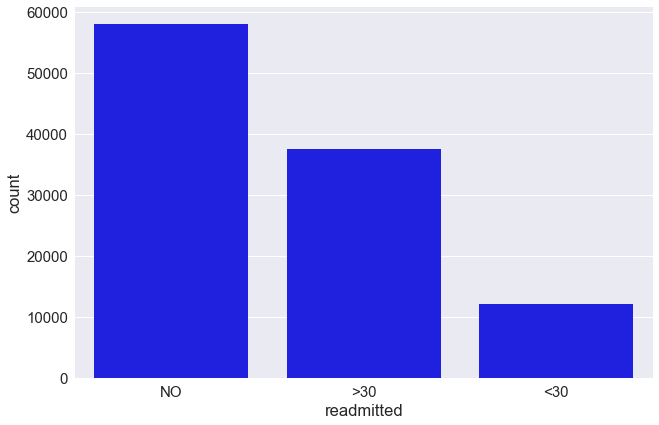

In [12]:
g = sns.factorplot(x="readmitted", data=dfdiagjoin, kind="count"
                   , size=6, aspect=1.5, color = "b" )
g.savefig('data_proportion.png', dpi = 300)

In [137]:
len(readmit.patient_nbr.unique()), len(notreadmit.patient_nbr.unique())

(8834, 69165)

## The dataset could generally be categorized as readmitted in under 30 days versus not, or the three categories could be used, under 30, over 30 and not. For simplicity I initially used two categories but this could partially be why my model did not perform well. There is class imbalance between readmitted < 30 and those not. Take a look at the variables and how they compare between the classes

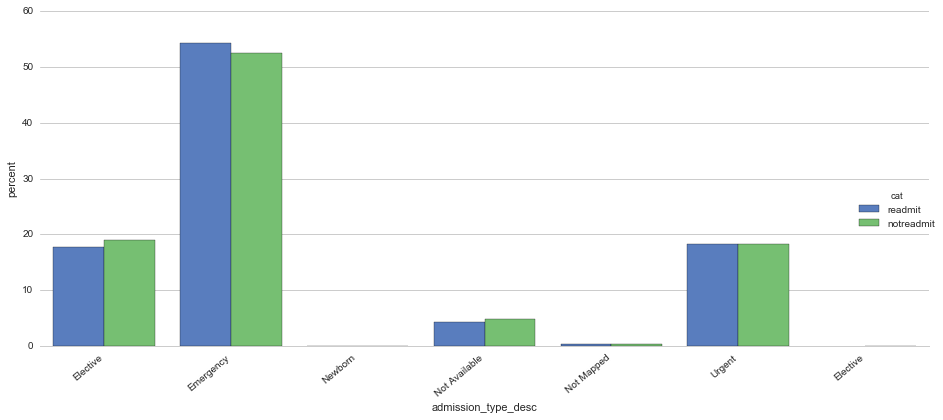

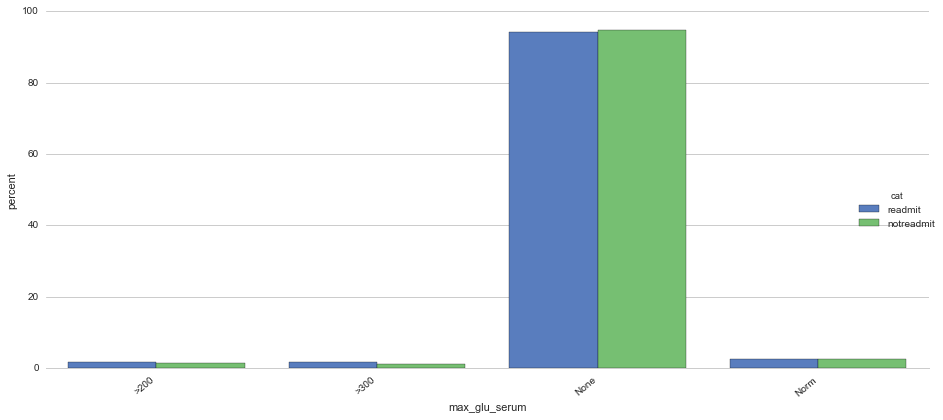

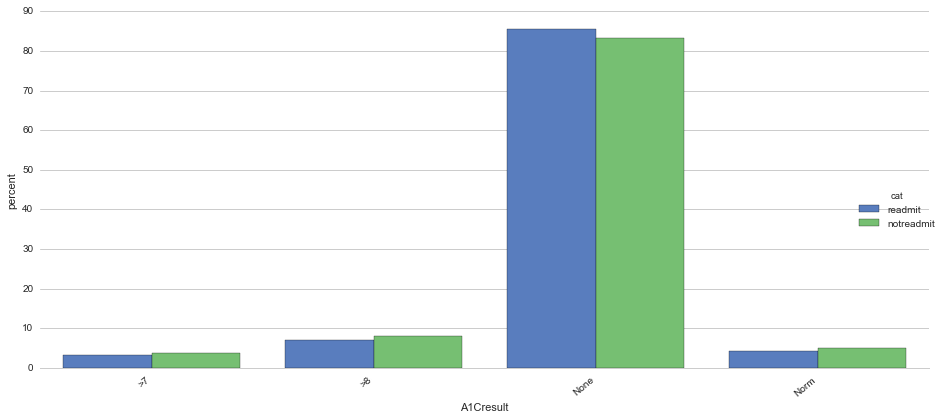

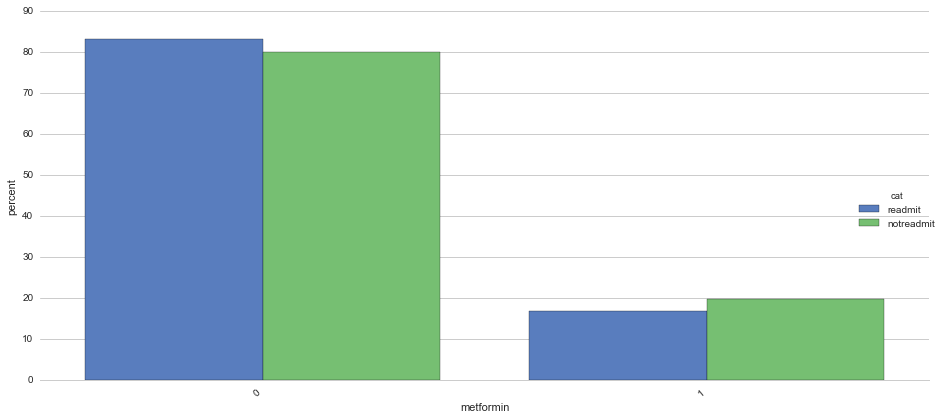

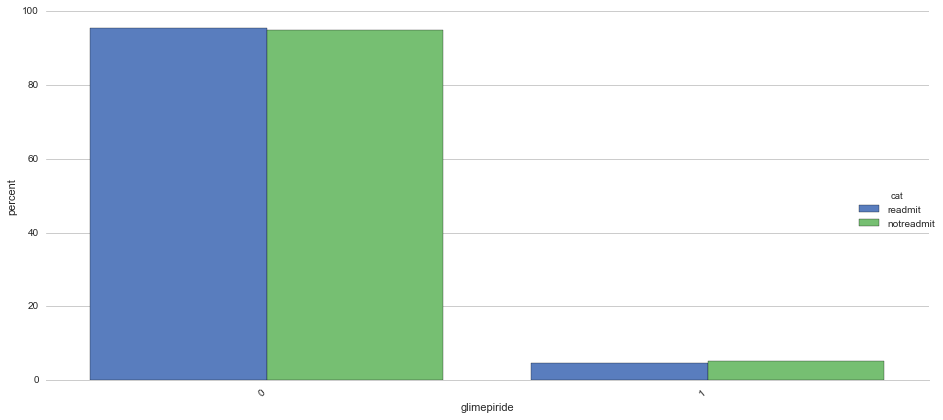

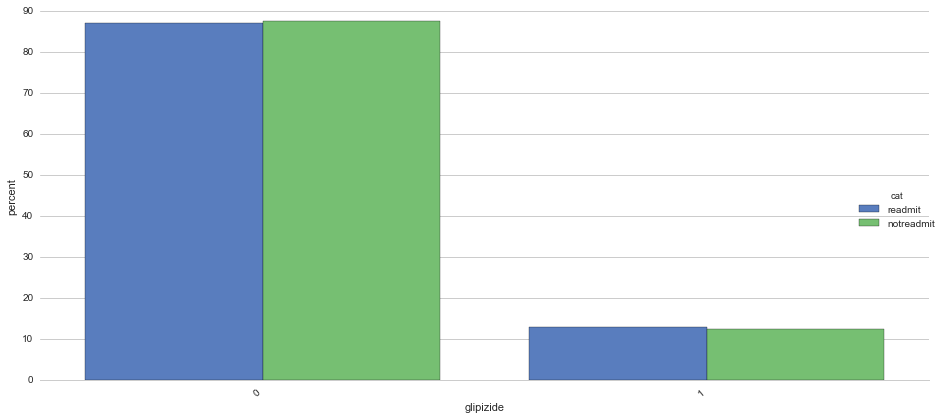

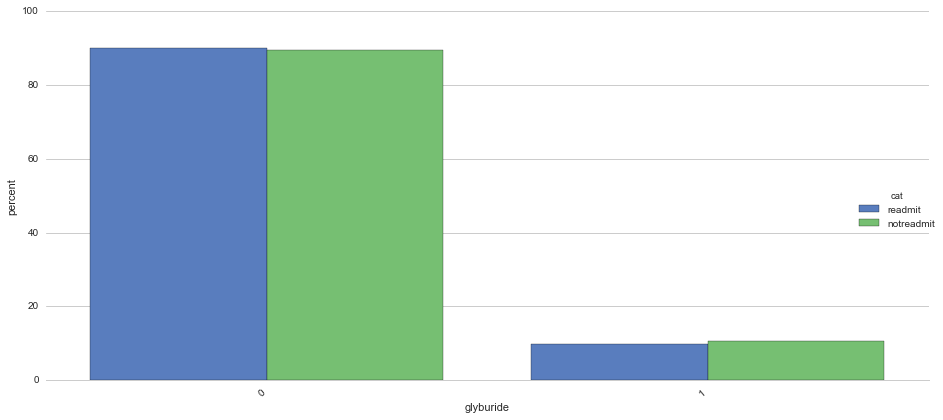

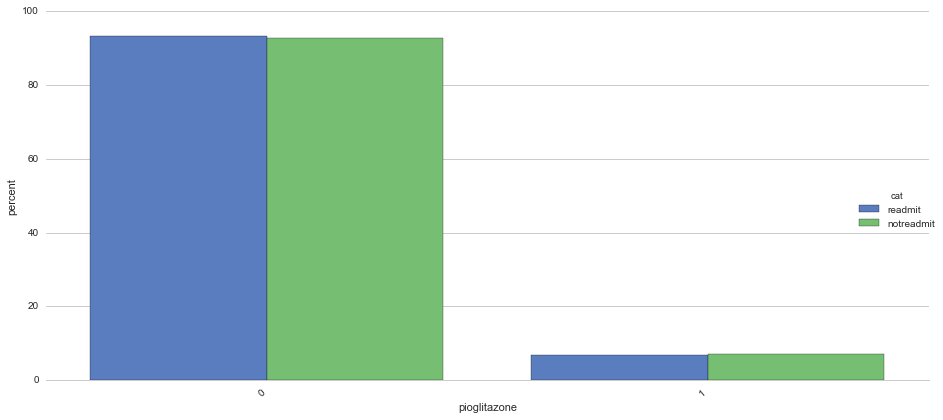

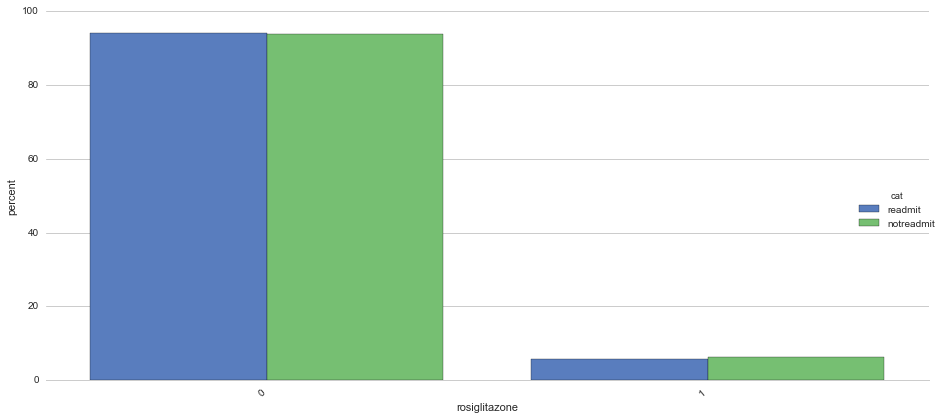

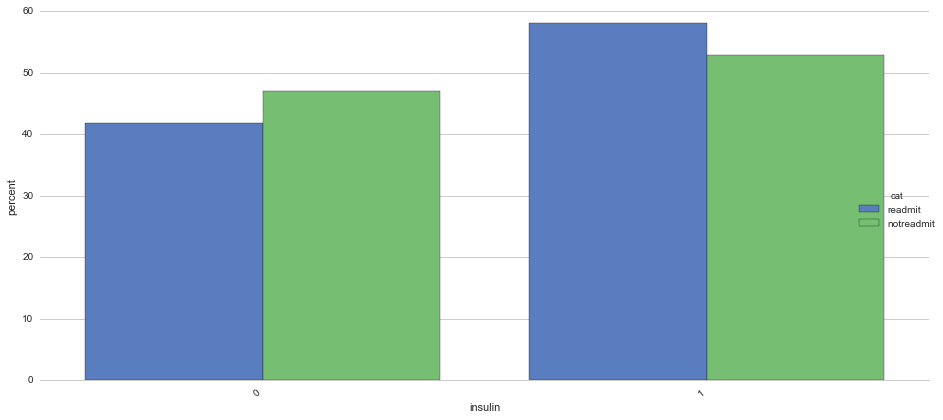

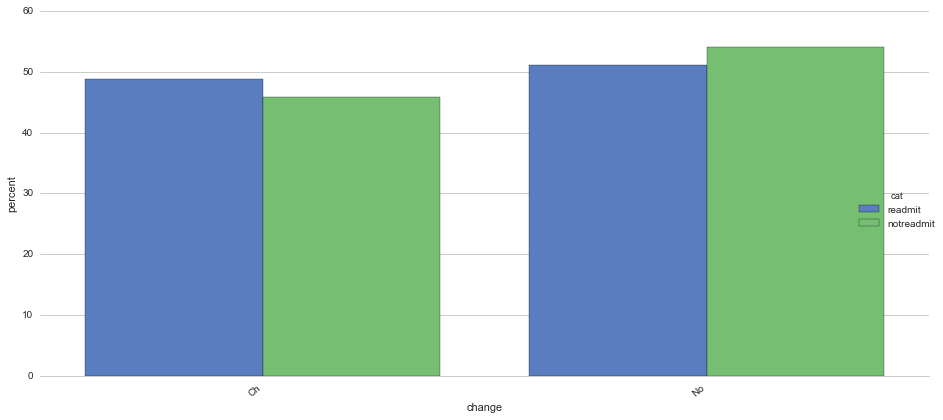

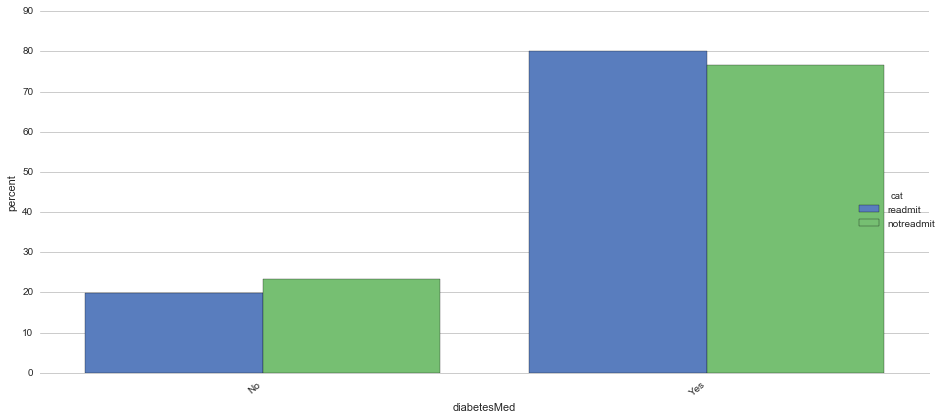

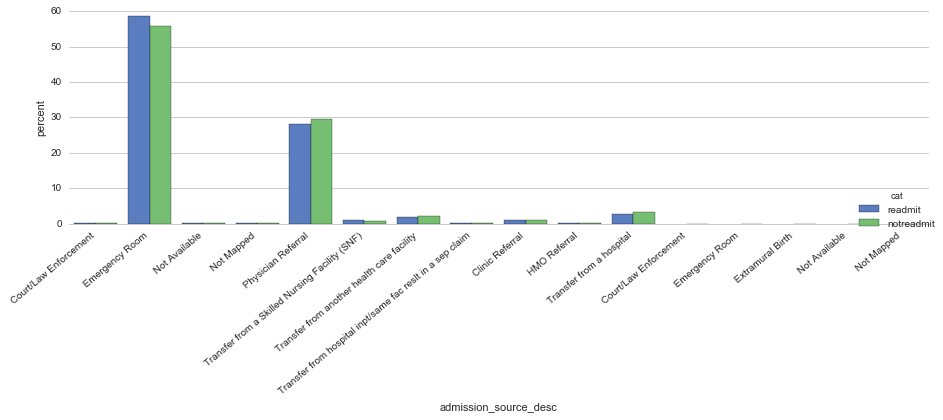

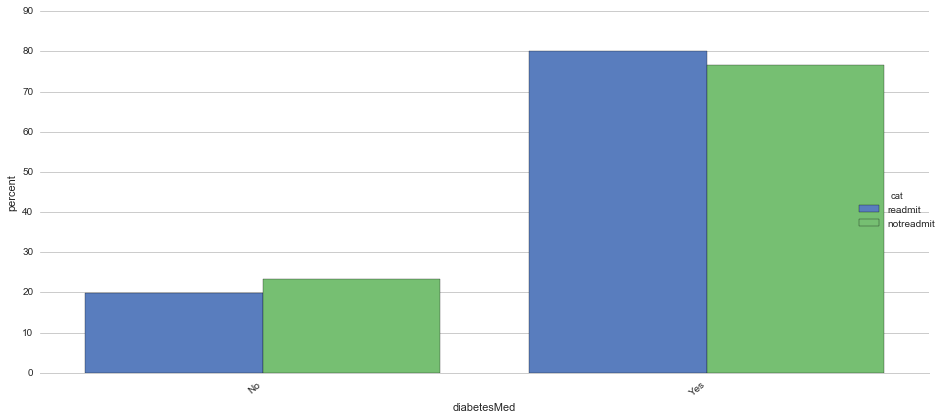

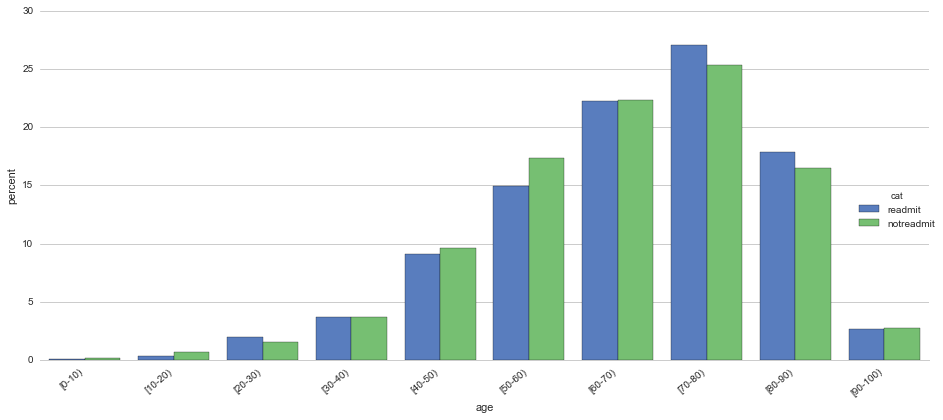

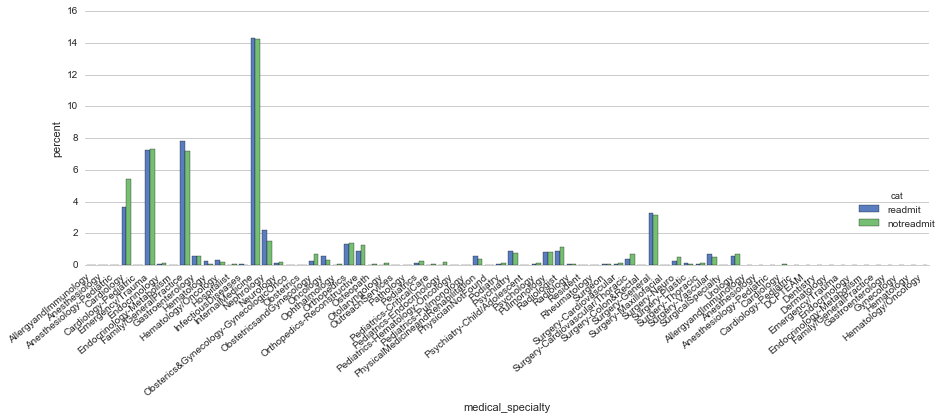

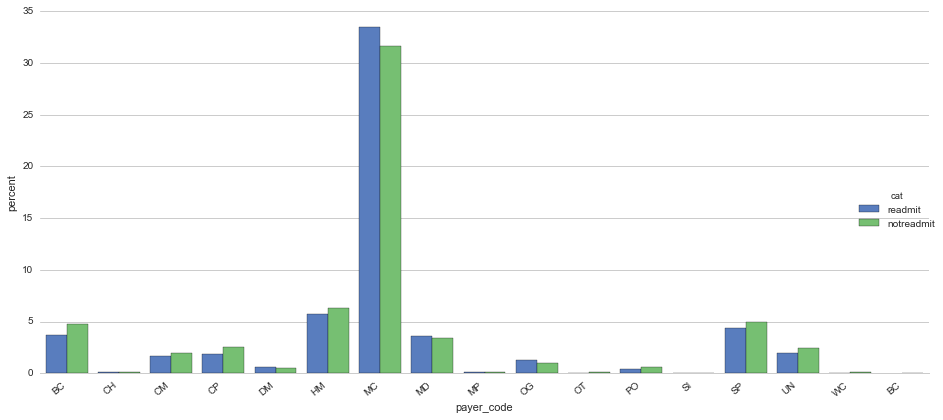

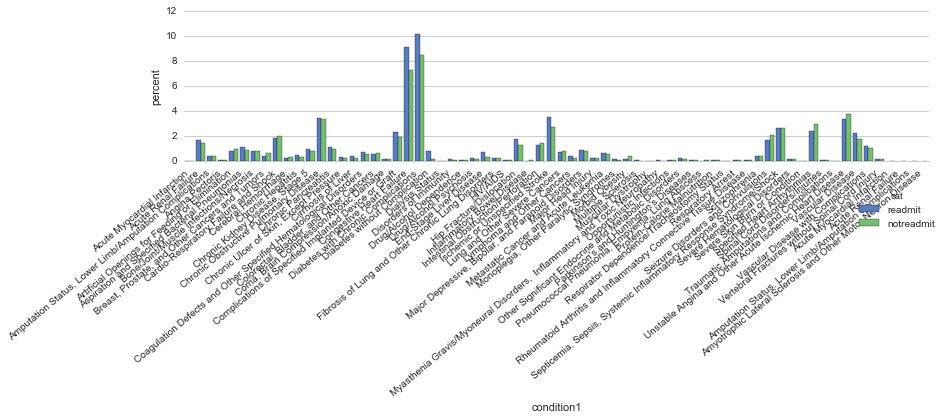

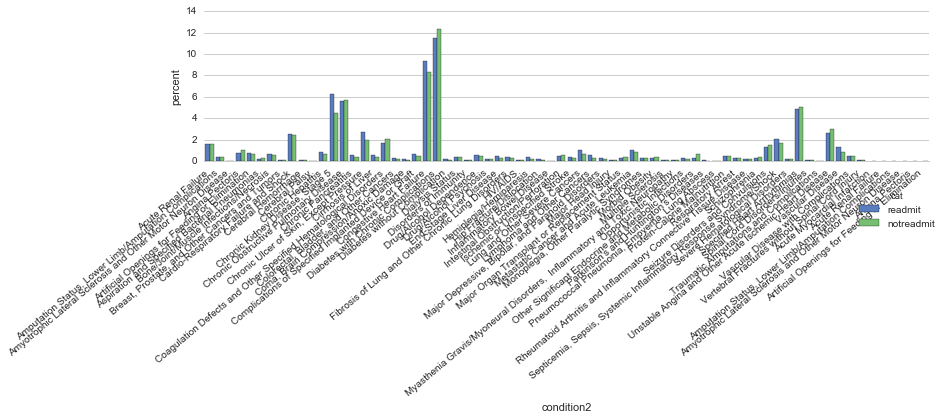

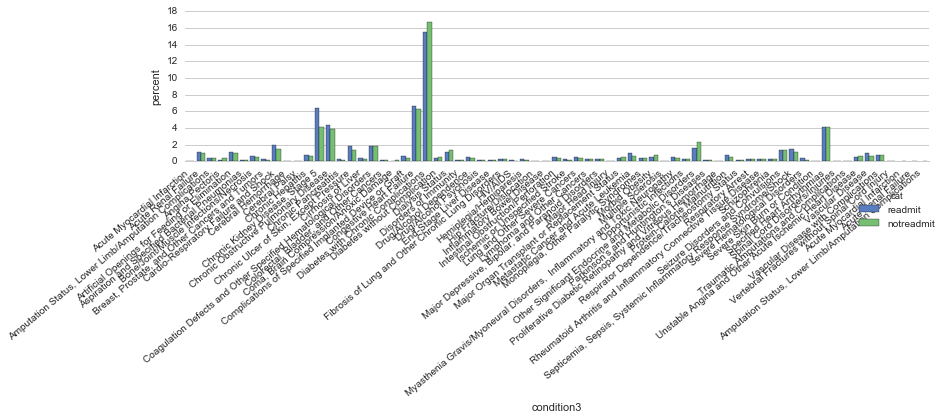

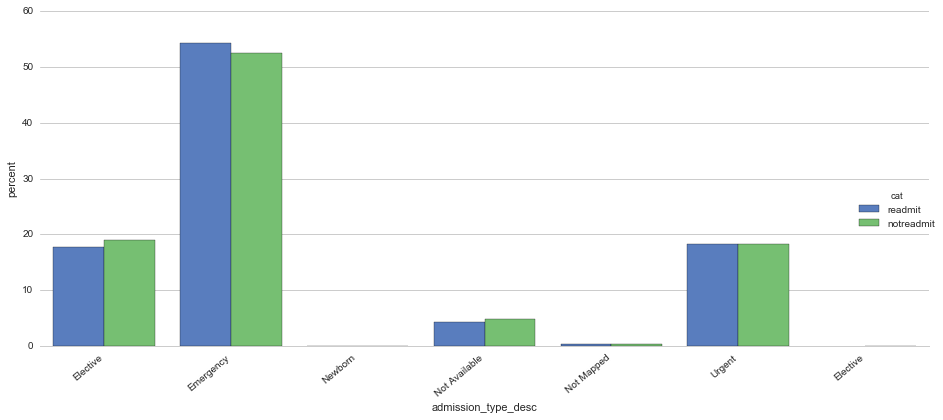

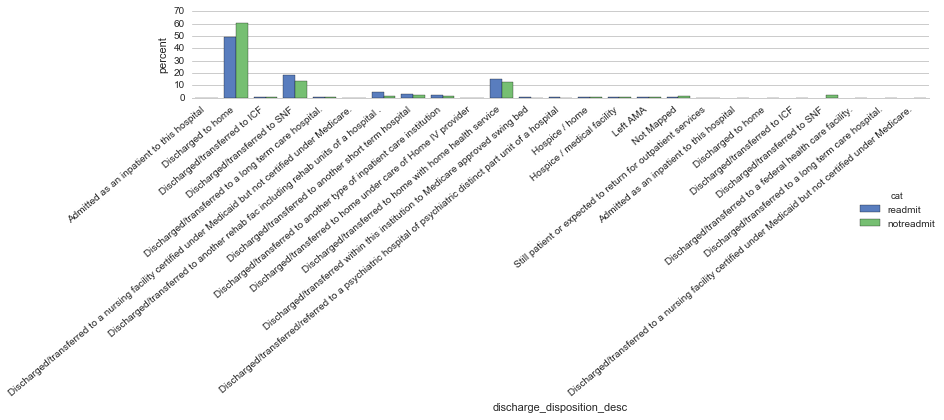

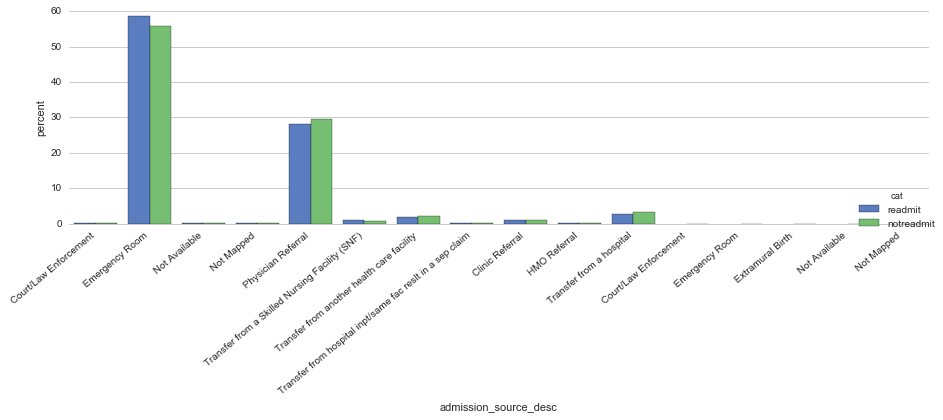

In [153]:
#for categorical variables, some such as conditions had too many which made it difficult to analyze
plt.figure() 
cols=['admission_type_desc',
       'max_glu_serum',
 'A1Cresult',
 'metformin',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'insulin',
 'change',
 'diabetesMed',
 'admission_source_desc',
 'diabetesMed',
      'age',
      'medical_specialty',
      'payer_code',
       'condition1',
 'condition2',
 'condition3',
       'admission_type_desc',
 'discharge_disposition_desc',
 'admission_source_desc',
 ]

import seaborn as sns
sns.set(style="whitegrid")
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
for i in cols:
    try:
        dfager = readmit.groupby([i]).size().reset_index()
        dfager.columns = [[i,'count']]
        dfager['percent'] = [x/len(readmit)*100 for x in dfager['count']]
        dfagenr = notreadmit.groupby([i]).size().reset_index()
        dfagenr.columns = [[i,'count']]
        dfagenr['percent'] = [x/len(notreadmit)*100 for x in dfagenr['count']]
        dfager['cat'] = 'readmit'
        dfagenr['cat'] = 'notreadmit'
        dfage = pd.concat([dfager,dfagenr])
        

        xlabels = dfage[i].tolist()
        sns_plot = sns.factorplot(x=i, y="percent", hue="cat", data=dfage, size=6, kind="bar", palette="muted",  aspect=2)
            
          
        sns_plot.despine(left=True)
        #sns_plot.set_xticklabels(rotation=90)
        sns_plot.set_xticklabels(xlabels, rotation=40, ha='right')
        sns_plot.savefig(i+ 'dist.png', dpi = 300)

    except:
        print i

## how about if separate into three target categories

In [159]:
readmit = dfdiagjoin[dfdiagjoin['readmitted']=='<30']
notreadmitno = dfdiagjoin[dfdiagjoin['readmitted']=='NO']
readmit30more =dfdiagjoin[dfdiagjoin['readmitted']=='>30']

In [25]:
len(readmit), len(notreadmitno), len(readmit30more) 

(12133, 57921, 37546)

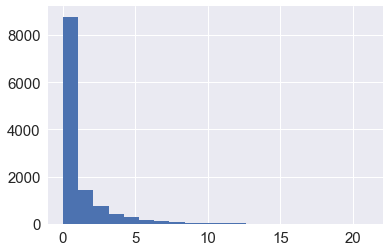

In [19]:
readmit['number_inpatient'].hist(bins = 20)

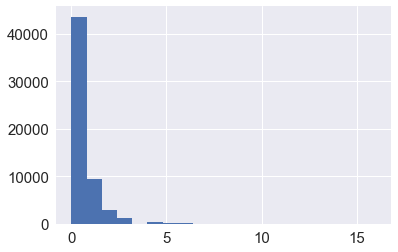

In [20]:
notreadmit['number_inpatient'].hist(bins = 20)

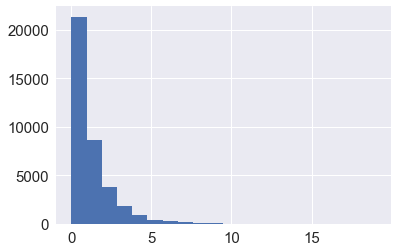

In [21]:
readmitover30['number_inpatient'].hist(bins = 20)

## still somewhat imbalances classes if classified into three groups

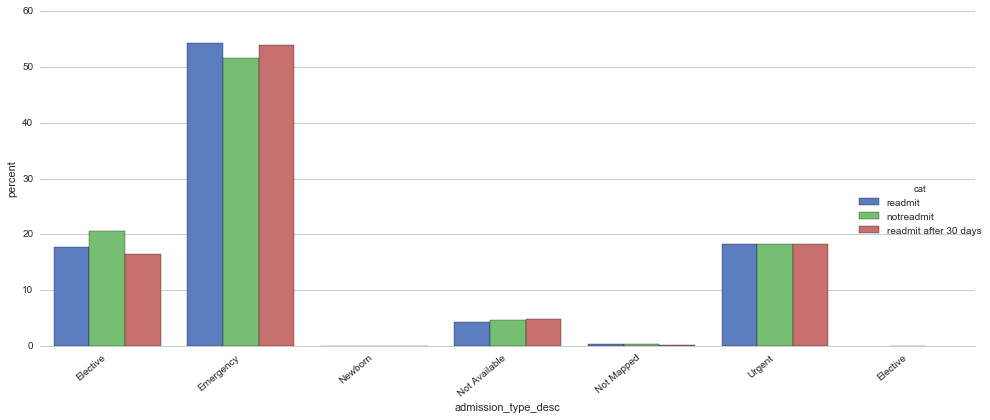

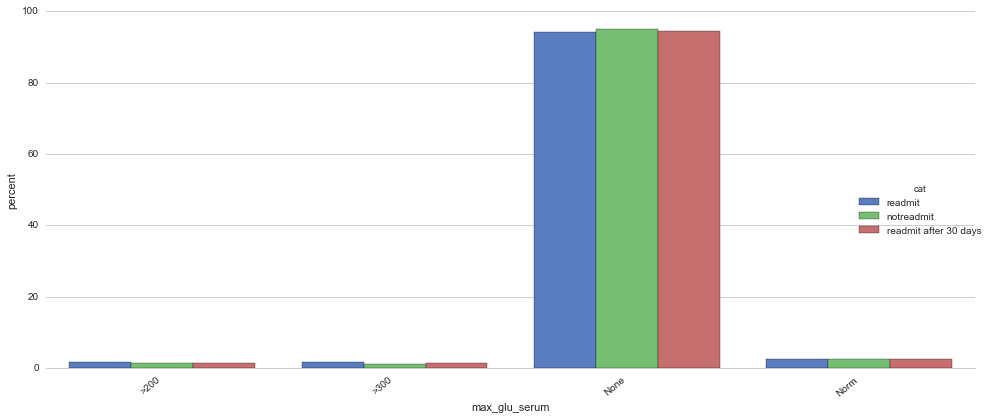

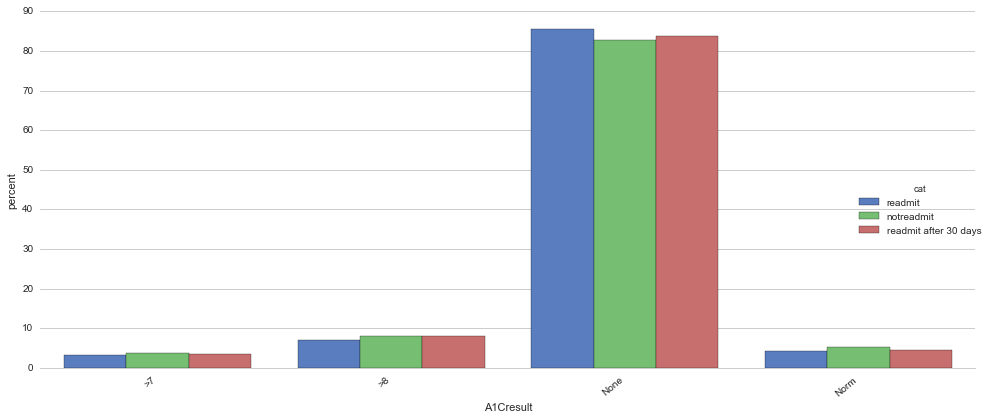

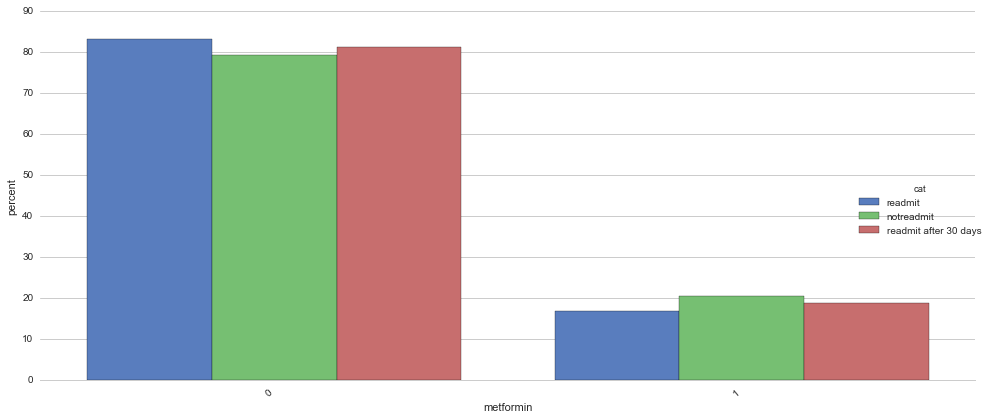

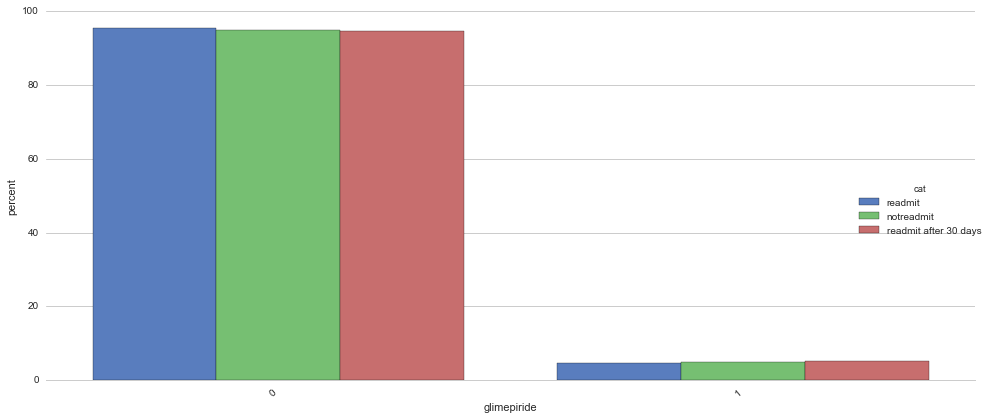

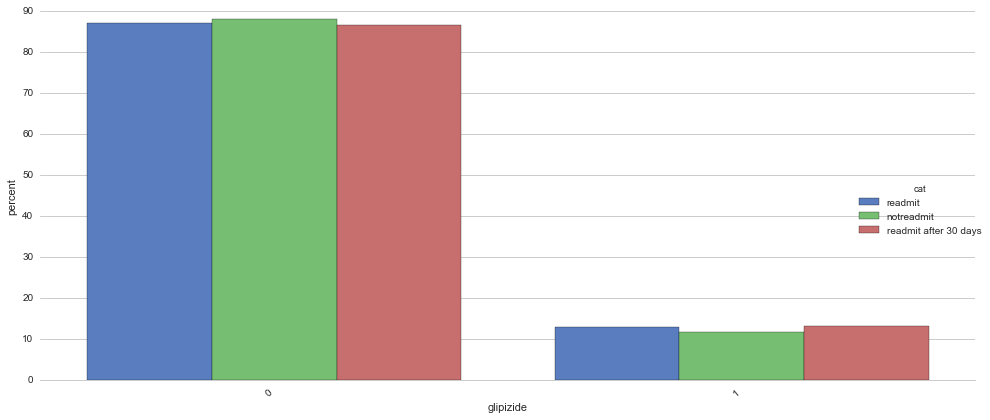

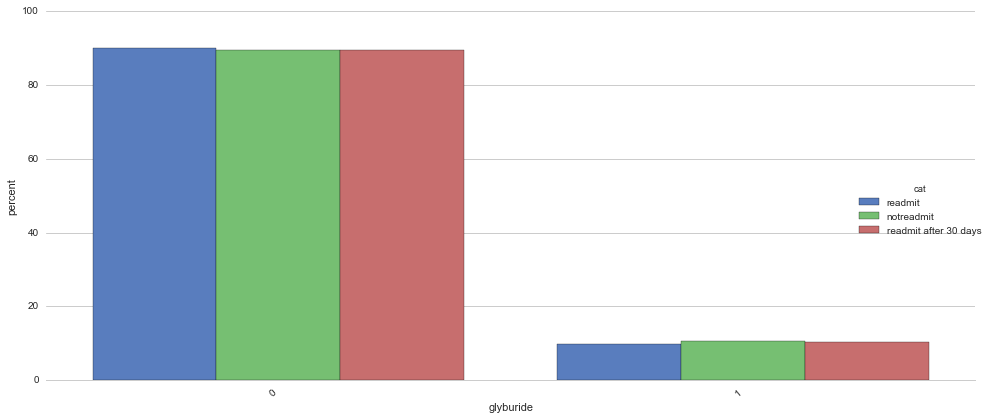

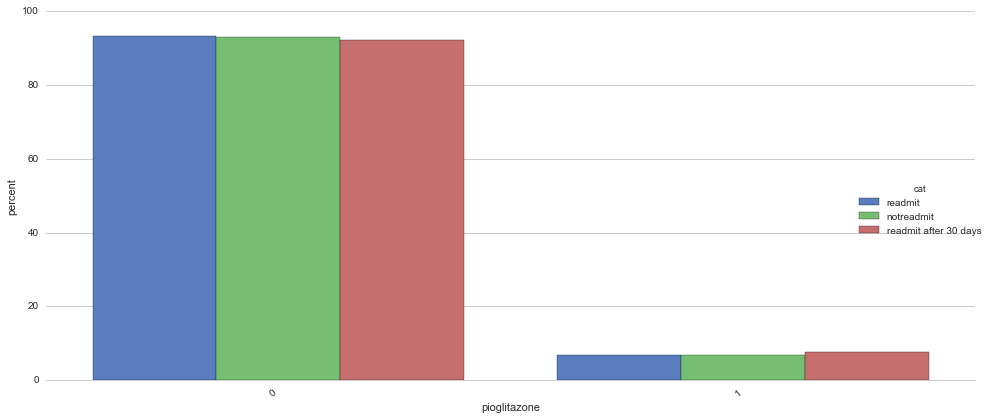

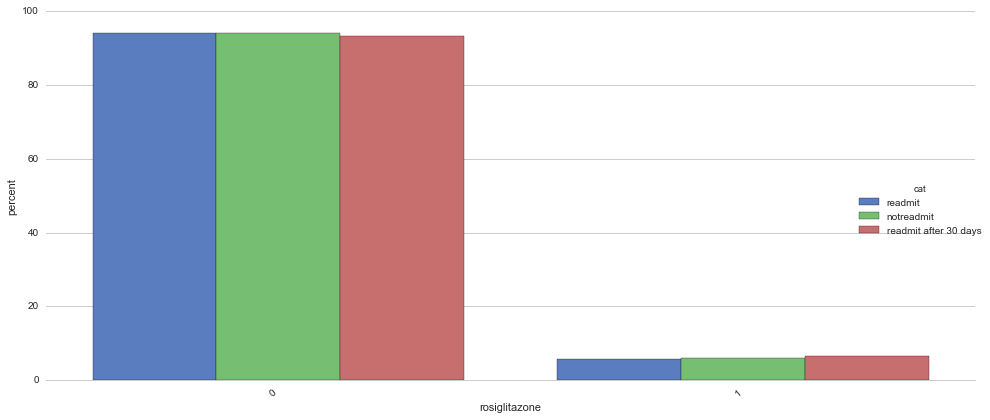

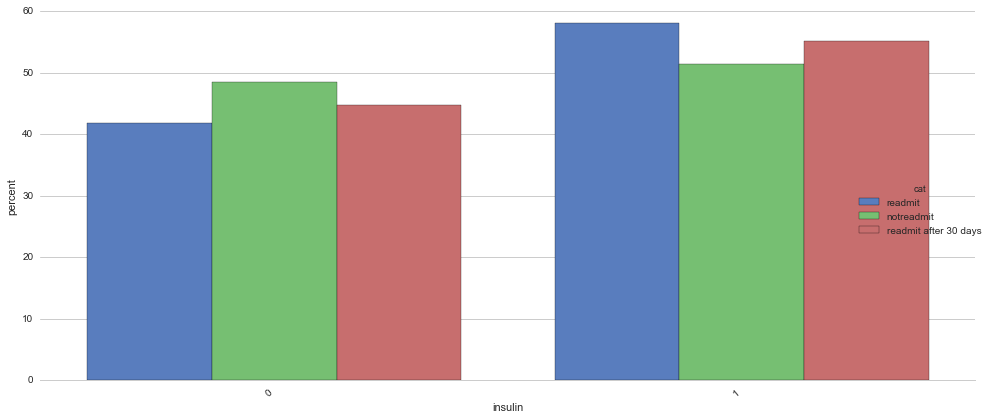

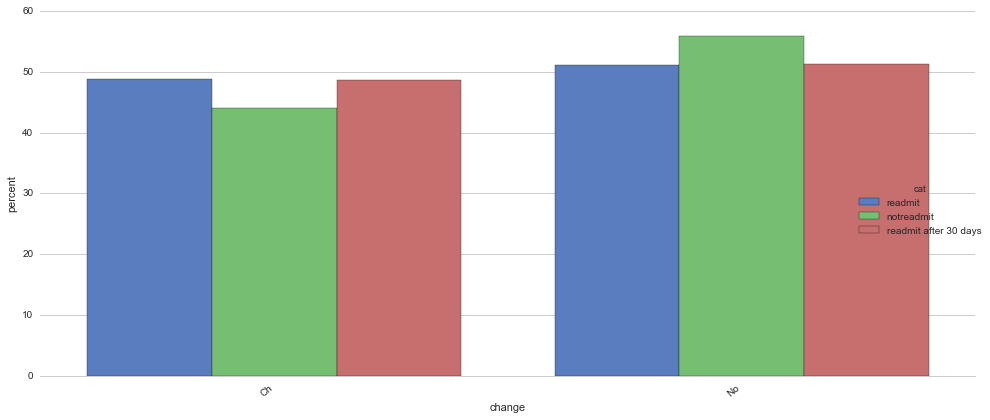

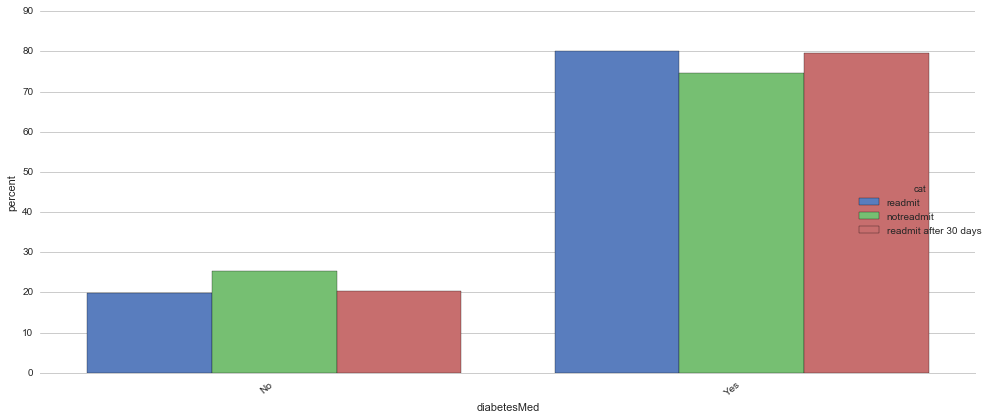

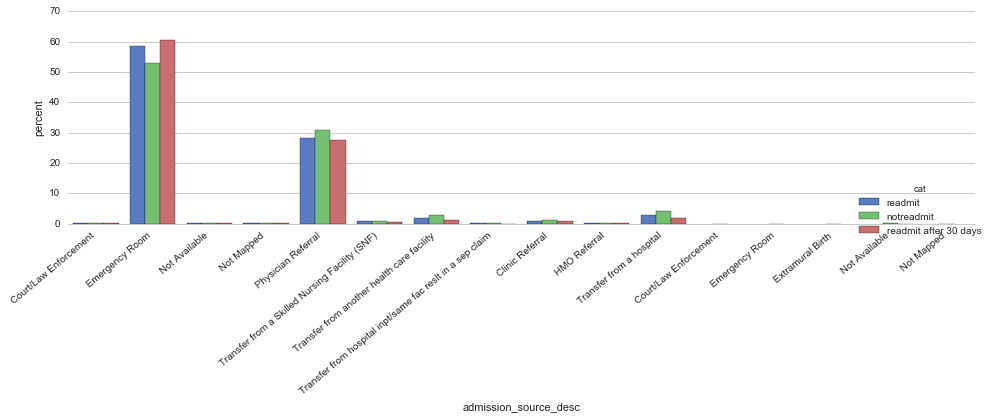

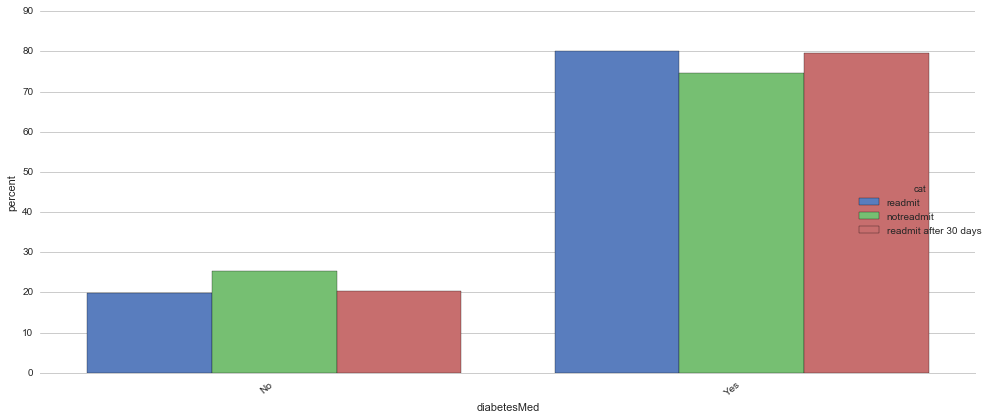

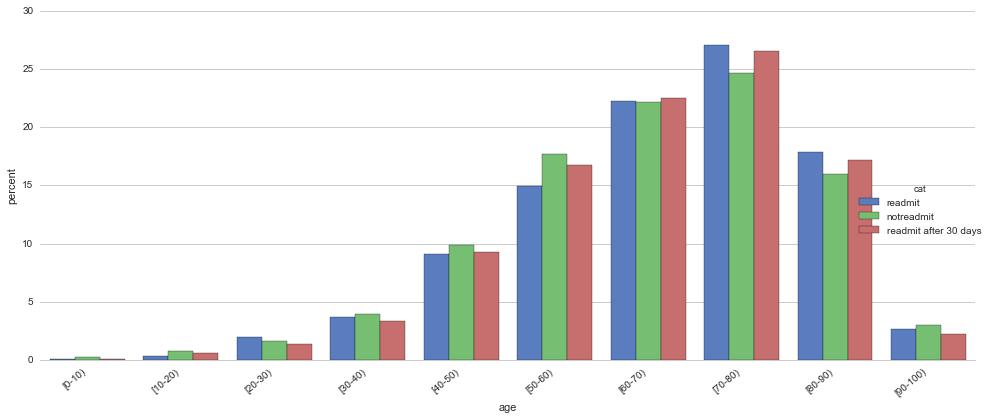

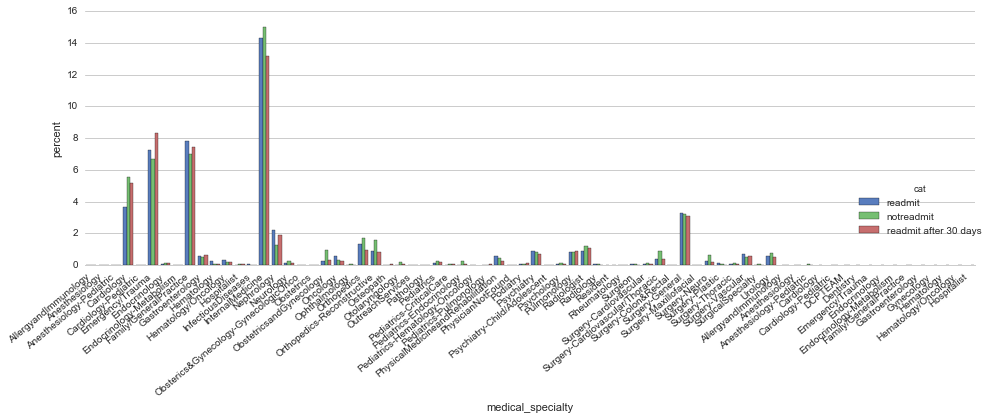

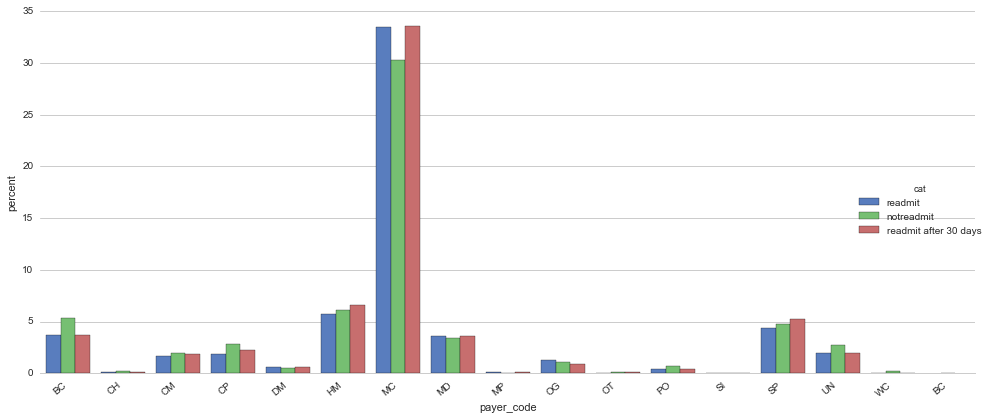

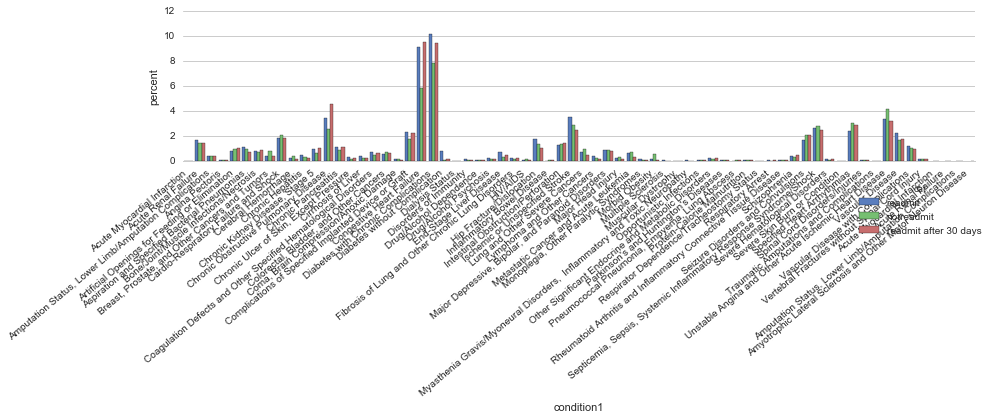

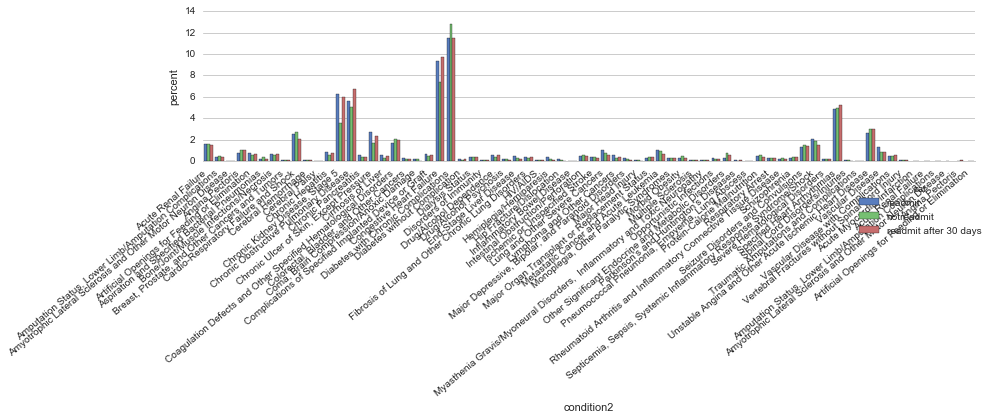

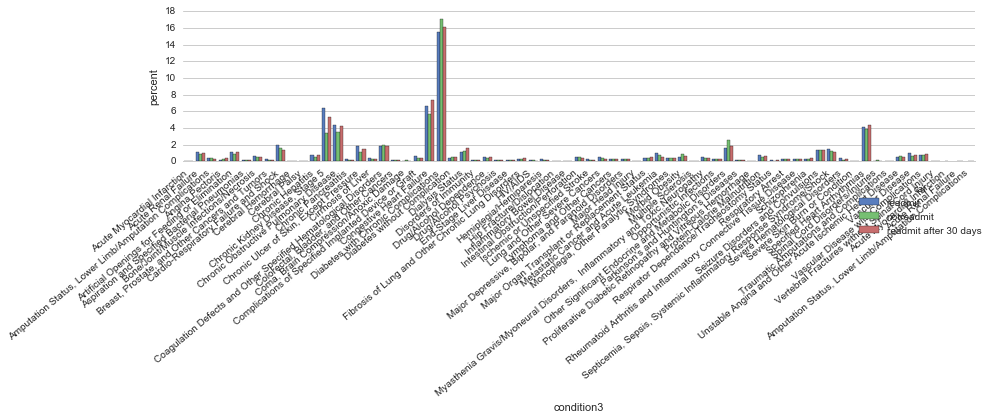

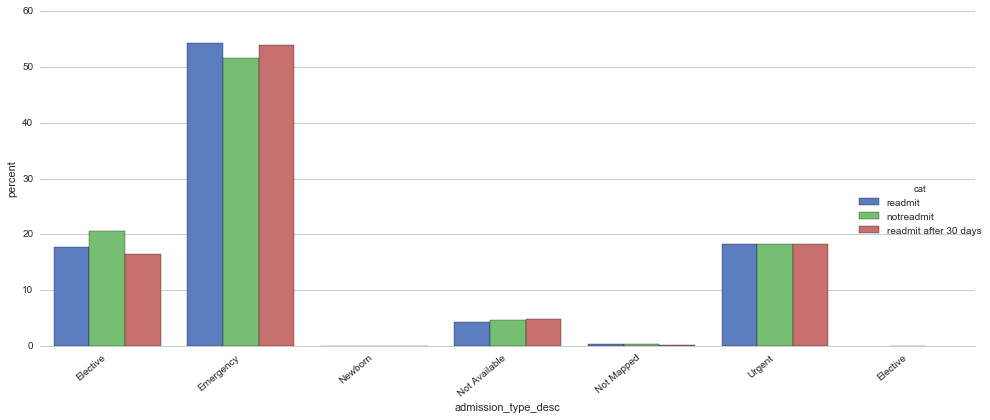

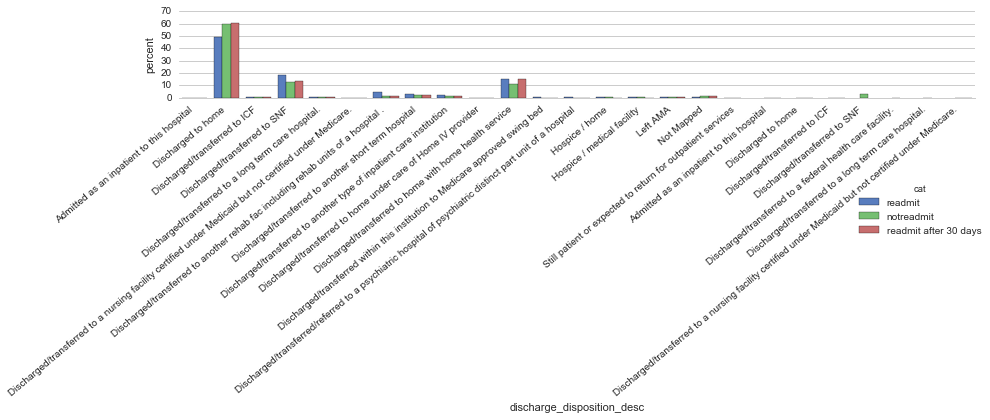

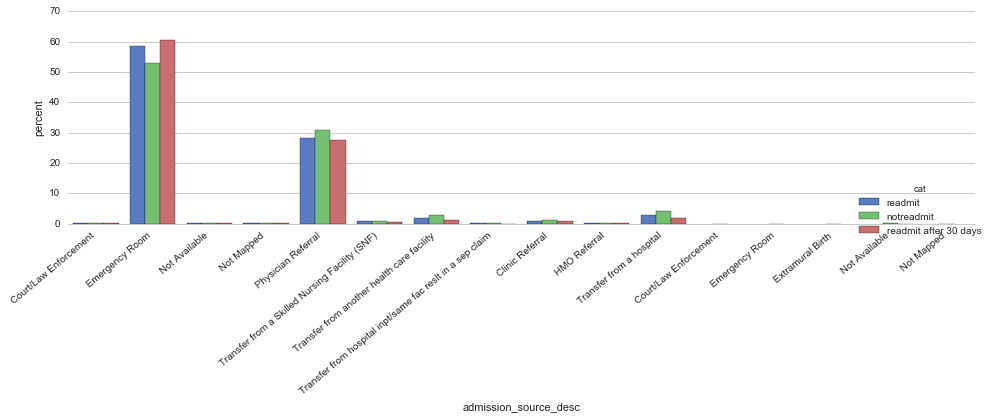

In [154]:
#for categorical variables, some such as conditions had too many which made it difficult to analyze
plt.figure() 
cols=['admission_type_desc',
       'max_glu_serum',
 'A1Cresult',
 'metformin',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'insulin',
 'change',
 'diabetesMed',
 'admission_source_desc',
 'diabetesMed',
      'age',
      'medical_specialty',
      'payer_code',
       'condition1',
 'condition2',
 'condition3',
       'admission_type_desc',
 'discharge_disposition_desc',
 'admission_source_desc',
 ]


for i in cols:
    try:
        dfager = readmit.groupby([i]).size().reset_index()
        dfager.columns = [[i,'count']]
        dfager['percent'] = [x/len(readmit)*100 for x in dfager['count']]
        dfagenr = notreadmitno.groupby([i]).size().reset_index()
        dfagenr.columns = [[i,'count']]
        dfagenr['percent'] = [x/len(notreadmitno)*100 for x in dfagenr['count']]
        dfagenr30 = readmit30more.groupby([i]).size().reset_index()
        dfagenr30.columns = [[i,'count']]
        dfagenr30['percent'] = [x/len(readmit30more)*100 for x in dfagenr30['count']]
        dfager['cat'] = 'readmit'
        dfagenr['cat'] = 'notreadmit'
        dfagenr30['cat'] = 'readmit after 30 days'
        dfage = pd.concat([dfager,dfagenr, dfagenr30])
        xlabels = dfage[i].tolist()
        sns_plot = sns.factorplot(x=i, y="percent", hue="cat", data=dfage,
                   size=6, kind="bar", palette="muted",  aspect=2)
        sns_plot.despine(left=True)
        #sns_plot.set_xticklabels(rotation=90)
        sns_plot.set_xticklabels(xlabels, rotation=40, ha='right')
        sns_plot.savefig(i+ 'dist_three_categories.png', dpi = 300)
    except:
        print i

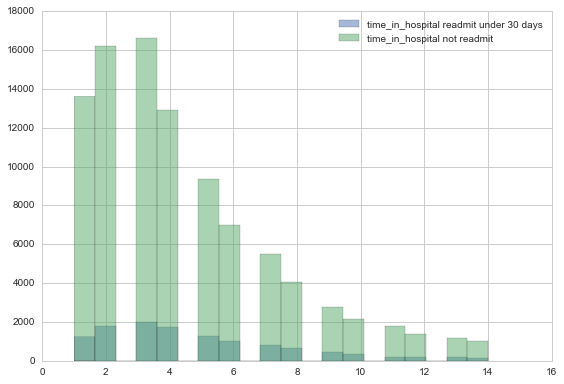

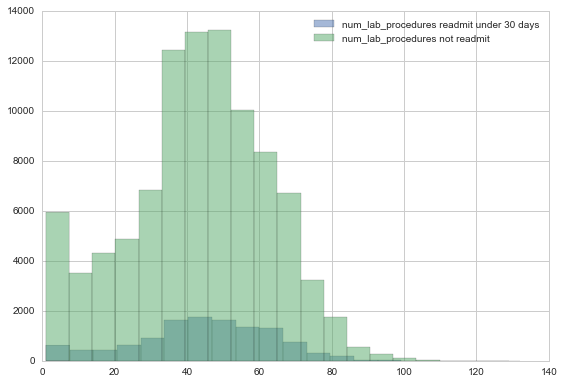

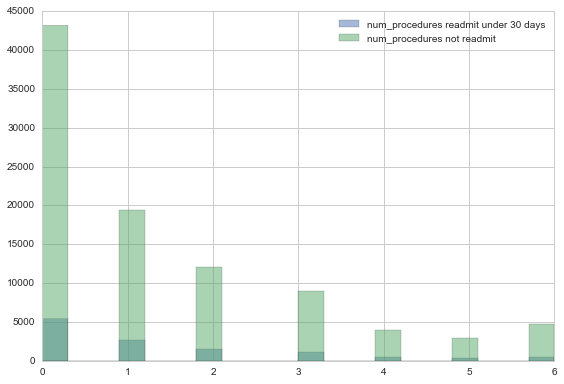

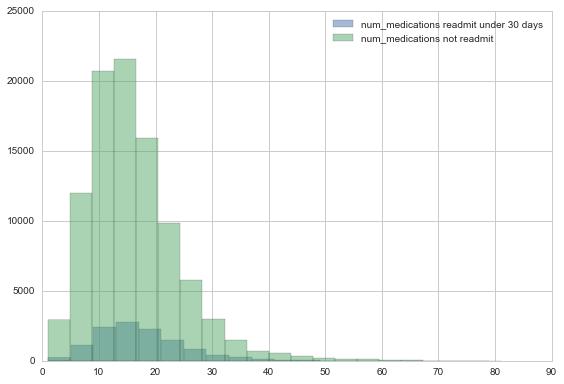

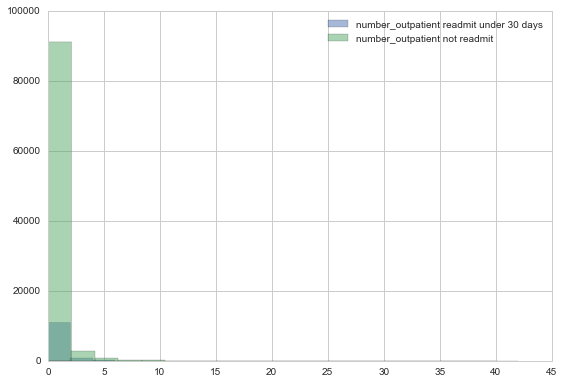

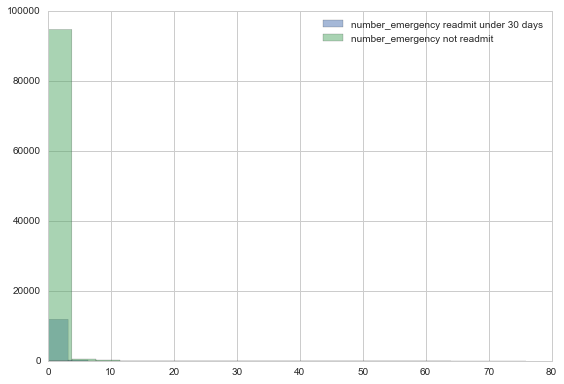

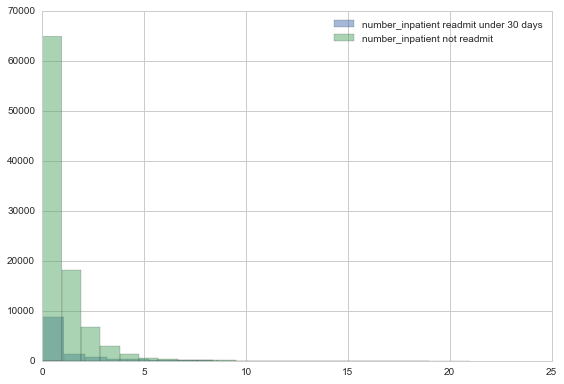

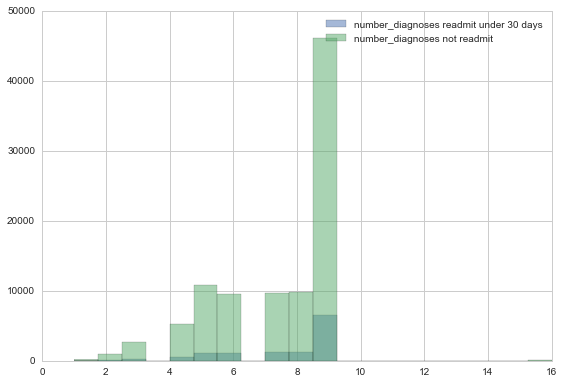

In [161]:
#for quantitative variables look at distributions
cols = [ 
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 ]
for i in cols:
    try:
        plt.hist(readmit[i], bins=20, alpha=0.5, label=i+' readmit under 30 days')
        plt.hist(notreadmit[i], bins=20, alpha=0.5, label=i+' not readmit')
        #plt.hist(readmit30more[i], bins=20, alpha=0.5, label=i+'readmit over 30 days')
        plt.legend(loc='upper right')
        
        plt.show()
        #plt.savefig(i+' hist_dist.png', dpi=300)
        #plt.clf()
    except:
        print i

In [162]:
#for quantitative variables look at distributions
cols = [ 
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 ]
for i in cols:
    try:
        plt.hist(readmit[i], bins=20, alpha=0.5, label=i+' readmit under 30 days')
        plt.hist(notreadmitno[i], bins=20, alpha=0.5, label=i+' not readmit')
        plt.hist(readmit30more[i], bins=20, alpha=0.5, label=i+' readmit more than 30 days')
        plt.legend(loc='upper right')
        
        plt.savefig(i +' hist_dist_three.png', dpi = 300)
        plt.clf()
    except:
        print i

## are the number of inpatient procedures significantly different between the three categories?

In [34]:
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

In [35]:
dfdiagjoinshort = dfdiagjoin[['number_inpatient', 'readmitted']]
model1 = smf.ols(formula='number_inpatient ~ C(readmitted)', data=dfdiagjoinshort)
results1 = model1.fit()
print (results1.summary())

                            OLS Regression Results                            
Dep. Variable:       number_inpatient   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3103.
Date:                Mon, 17 Apr 2017   Prob (F-statistic):               0.00
Time:                        21:59:51   Log-Likelihood:            -1.7524e+05
No. Observations:              107600   AIC:                         3.505e+05
Df Residuals:                  107597   BIC:                         3.505e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                1.2313 

In [36]:
mc1 = multi.MultiComparison(dfdiagjoinshort['number_inpatient'], dfdiagjoinshort['readmitted'])
res1 = mc1.tukeyhsd()
print(res1.summary()) #looks like all three groups have potentially different numbers of inpatient procedures

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 <30    >30   -0.3845  -0.4147 -0.3544  True 
 <30     NO   -0.8404  -0.8693 -0.8116  True 
 >30     NO   -0.4559   -0.475 -0.4367  True 
---------------------------------------------


In [37]:
m1= dfdiagjoinshort.groupby('readmitted').mean()
print (m1)

            number_inpatient
readmitted                  
<30                 1.231270
>30                 0.846721
NO                  0.390825


In [38]:
sd2 = dfdiagjoinshort.groupby('readmitted').std()
print (sd2)

            number_inpatient
readmitted                  
<30                 1.948163
>30                 1.399226
NO                  0.872796


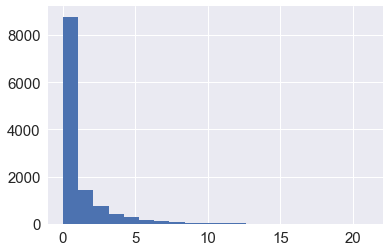

In [24]:
readmit['number_inpatient'].hist(bins = 20)

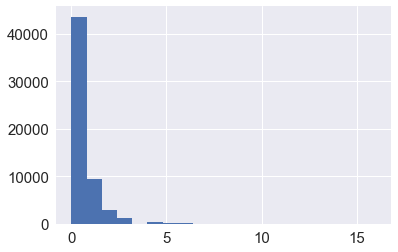

In [25]:
notreadmit['number_inpatient'].hist(bins = 20)

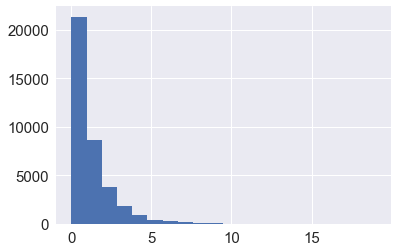

In [23]:
readmitover30['number_inpatient'].hist(bins = 20)

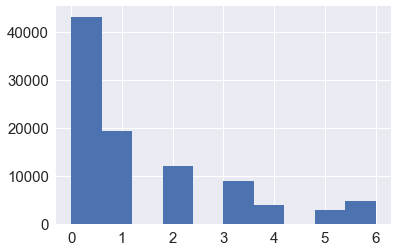

In [52]:
notreadmit['num_procedures'].hist()

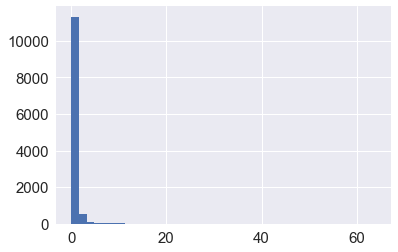

In [60]:
readmit['number_emergency'].hist(bins = 40) #longer tail than not readmitted

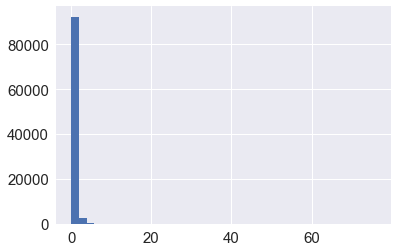

In [61]:
notreadmit['number_emergency'].hist(bins = 40)

## preliminarily no one column stands out as having obvious differences in distribution between readmitted and not readmitted patients.

In [138]:
#medical specialty and payer codes are over 50% missing. considering dropping these since looking at the proportions
#of each category there is no clear difference in readmitted versus not except some specialties like cardilogy
len(dfdiagjoin), len(dfdiagjoin[dfdiagjoin['medical_specialty'].isnull()])

(107600, 52833)

In [139]:
len(dfdiagjoin), len(dfdiagjoin[dfdiagjoin['payer_code'].isnull()])

(107600, 42600)

In [143]:
dfdiagjoin.readmitted.unique()

array(['NO', '>30', '<30'], dtype=object)

In [63]:
def get_target(x):
    if x == '<30':
        return 1
    else:
        return 0
dfdiagjoin['target'] = [get_target(x) for x in dfdiagjoin['readmitted']]

In [236]:
len(dfdiagjoin[dfdiagjoin['target']==1]), len(dfdiagjoin[dfdiagjoin['target']==0])

(12133, 95467)

## random forest can not handle missing values so for now drop payer code and put 'none' for medical specialty NaNs


In [65]:
dfdiagjoin['medical_specialty'].fillna('none', inplace=True)

In [66]:
dfdiagjoin['payer_code'].fillna('none', inplace=True)

In [67]:
dfdiagjoin.fillna('none', inplace = True)

In [152]:
dfdiagjoin.head(2)

encounter_id  patient_nbr       race  gender      age  time_in_hospital  \
0       2278392      8222157  Caucasian  Female   [0-10)                 1   
1        149190     55629189  Caucasian  Female  [10-20)                 3   

  payer_code         medical_specialty  num_lab_procedures  num_procedures  \
0       none  Pediatrics-Endocrinology                  41               0   
1       none                      none                  59               0   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
0                1                  0                 0                 0   
1               18                  0                 0                 0   

   number_diagnoses max_glu_serum A1Cresult  metformin  glimepiride  \
0                 1          None      None          0            0   
1                 9          None      None          0            0   

   glipizide  glyburide  pioglitazone  rosiglitazone  insulin change  \
0          0          0             0              0        0     No   
1          0          0             0              0        1     Ch   

  diabetesMed readmitted admission_type_desc discharge_disposition_desc  \
0          No         NO                none                 Not Mapped   
1         Yes        >30           Emergency         Discharged to home   

  admission_source_desc                           condition1  \
0    Physician Referral  Diabetes with Chronic Complications   
1        Emergency Room                                 none   

                            condition2  \
0                                 none   
1  Diabetes with Chronic Complications   

                                          condition3  target  
0                                               none       0  
1  Other Significant Endocrine and Metabolic Diso...       0

In [68]:
#have to combine three condition columns but for now just going ahead
#now do the random forest
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, cross_validation
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import random
from sklearn import grid_search
import seaborn as sns
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 3})
%matplotlib inline

In [155]:
#save
dfdiagjoin.to_csv('041617_diagnosis_join_cleaned.csv', index = False)

In [4]:
dfdiagjoin = pd.read_csv('041617_diagnosis_join_cleaned.csv')

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics
 # Feature Importance
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier

## first fix the diagnosis columns, convert into one column, turn to dummies then join with the rest of the data


In [69]:
diagfix = dfdiagjoin[['encounter_id','condition1','condition2','condition3']]

In [70]:
diagfix1 = dfdiagjoin[['encounter_id','condition1']]
diagfix2 = dfdiagjoin[['encounter_id','condition2']]
diagfix3 = dfdiagjoin[['encounter_id','condition3']]

In [71]:
diagfix1.columns = [['encounter_id','condition']]
diagfix2.columns = [['encounter_id','condition']]
diagfix3.columns = [['encounter_id','condition']]

In [72]:
alldiag = pd.concat([diagfix1,diagfix2,diagfix3])

In [73]:
#remove duplicates and 'none', biggest issue is if one id has two or more diagnoses
alldiag = alldiag.drop_duplicates()


In [74]:
alldiag = alldiag[alldiag['condition']!= 'none']

In [75]:
alldiagdummy = pd.get_dummies(alldiag['condition'])

In [76]:
alldiagdummy2 = pd.concat([alldiag, alldiagdummy],1)

In [78]:
del alldiagdummy2['condition']

In [79]:
diagg =alldiagdummy2.groupby(['encounter_id']).sum().reset_index() 
#sum by encounter so if one encounter had three diagnoses, each would be labeled 1

In [19]:
#ids with no joined conditions need to be added and given 0s across all diagnoses
len(dfdiagjoin.encounter_id.unique()), len(alldiagdummy2.encounter_id.unique()) 


(101766, 96272)

## some of these have no diagnosis, need to include these! add them back and give them all zeros. or give them the category 'none' they may have diagnoses but just ones that didn't join with the table, or they don't have any. take a look at their data.

In [20]:
allencounters = dfdiagjoin.encounter_id.unique()
encountersdiag = diagg.encounter_id.unique()

In [21]:
nodiag=[]
for i in allencounters:
    if i not in encountersdiag:
        nodiag.append(i)

In [22]:
diagfix[diagfix['encounter_id'].isin(nodiag)].head()

encounter_id condition1 condition2 condition3
45         421194       none       none       none
73         796152       none       none       none
81         964548       none       none       none
89        1110420       none       none       none
136       2226870       none       none       none

In [70]:
dfjoin[dfjoin['encounter_id'].isin(nodiag)].head()

encounter_id  patient_nbr             race  gender      age weight  \
42         421194     96435585        Caucasian  Female  [70-80)      ?   
68         796152     23043240        Caucasian  Female  [50-60)      ?   
76         964548    106469577  AfricanAmerican    Male  [60-70)      ?   
83        1110420     96190083        Caucasian    Male  [60-70)      ?   
130       2226870     58471101        Caucasian  Female  [50-60)      ?   

    admission_type_id discharge_disposition_id admission_source_id  \
42                  2                        1                   1   
68                  2                        1                   4   
76                  1                        1                   7   
83                  1                        1                   7   
130                 2                        6                   4   

     time_in_hospital payer_code medical_specialty  num_lab_procedures  \
42                 13          ?                 ?                  48   
68                  2          ?                 ?                  32   
76                  1          ?                 ?                  58   
83                  1          ?                 ?                  59   
130                 6          ?                 ?                  66   

     num_procedures  num_medications  number_outpatient  number_emergency  \
42                2               18                  0                 0   
68                3               11                  0                 0   
76                1               12                  0                 0   
83                0               10                  0                 0   
130               0               15                  1                 0   

     number_inpatient diag_1 diag_2 diag_3  number_diagnoses max_glu_serum  \
42                  1    V57    276    781                 8          None   
68                  0    414    424    424                 9          None   
76                  0    786    396    414                 6          None   
83                  0    564    414    794                 7          None   
130                 2    599    276    789                 9          None   

    A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
42       None    Steady          No          No             No          No   
68       None        No          No          No             No          No   
76       None        No          No          No             No          No   
83       None        No          No          No             No          No   
130      None        No          No          No             No          No   

    acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
42             No        No    Steady          No           No            No   
68             No        No        No          No           No            No   
76             No        No    Steady          No           No            No   
83             No    Steady        No          No           No            No   
130            No        No        No          No           No            No   

    acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
42        No       No           No         No      No          No  Steady   
68        No       No           No         No      No          No  Steady   
76        No       No           No         No      No          No      No   
83        No       No           No         No      No          No    Down   
130       No       No           No         No      No          No  Steady   

    glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
42                   No                  No                       No   
68                   No                  No                       No   
76                   No                  No                       No   
83                   No                  No            

## they have diagnoses just not ones joined to conditions in the mapping table

In [80]:
#join back
dfdiagdum = dfdiagjoin.merge(diagg, on = ['encounter_id'], how = 'left')

In [81]:
#replace NaNs with zeros for unjoined dummy variables
dfdiagdum2 = dfdiagdum.fillna(0)


In [82]:
#remove condition columns
del dfdiagdum2['condition1']
del dfdiagdum2['condition2']
del dfdiagdum2['condition3']

In [83]:
#consider making it three classes
def get_target(x):
    if x == '<30':
        return 1
    if x == '>30':
        return 2
    if x == 'NO':
        return 0
dfdiagdum2['target2'] = [get_target(x) for x in dfdiagdum2['readmitted']]

In [84]:
dfdiagdum2.to_csv('041617_cleaned_data_diagnosis_dummy.csv', index = False)

In [39]:
dfdiagdum2= pd.read_csv('041617_cleaned_data_diagnosis_dummy.csv')


In [95]:
dfdiagdum2.target2.unique()

array([0, 2, 1], dtype=int64)

## now separate out columns to get dummies on, from the numeric columns, join back and try a few models

In [198]:
dfdummies=pd.get_dummies(dfdiagdum2[['race', 'gender', 'max_glu_serum','A1Cresult',
                                     'change','diabetesMed','admission_type_desc','discharge_disposition_desc',
                                     'admission_source_desc' ]])

In [199]:
#include dummy variables for conditions
x_num = dfdiagdum2[['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient',
                     'number_emergency','number_inpatient','number_diagnoses','metformin','glimepiride','glipizide',
                     'glyburide','pioglitazone','rosiglitazone','insulin','Acute Myocardial Infarction',
 'Acute Renal Failure',
 'Amputation Status, Lower Limb/Amputation Complications',
 'Amyotrophic Lateral Sclerosis and Other Motor Neuron Disease',
 'Angina Pectoris',
 'Artificial Openings for Feeding or Elimination',
 'Aspiration and Specified Bacterial Pneumonias',
 'Atherosclerosis of the Extremities with Ulceration or Gangrene',
 'Bone/Joint/Muscle Infections/Necrosis',
 'Breast, Prostate, and Other Cancers and Tumors',
 'Cardio-Respiratory Failure and Shock',
 'Cerebral Hemorrhage',
 'Cerebral Palsy',
 'Chronic Hepatitis',
 'Chronic Kidney Disease, Stage 5',
 'Chronic Obstructive Pulmonary Disease',
 'Chronic Pancreatitis',
 'Chronic Ulcer of Skin, Except Pressure',
 'Cirrhosis of Liver',
 'Coagulation Defects and Other Specified Hematological Disorders',
 'Colorectal, Bladder, and Other Cancers',
 'Coma, Brain Compression/Anoxic Damage',
 'Complications of Specified Implanted Device or Graft',
 'Congestive Heart Failure',
 'Diabetes with Chronic Complications',
 'Diabetes without Complication',
 'Dialysis Status',
 'Disorders of Immunity',
 'Drug/Alcohol Dependence',
 'Drug/Alcohol Psychosis',
 'End-Stage Liver Disease',
 'Fibrosis of Lung and Other Chronic Lung Disorders',
 'HIV/AIDS',
 'Hemiplegia/Hemiparesis',
 'Hip Fracture/Dislocation',
 'Inflammatory Bowel Disease',
 'Intestinal Obstruction/Perforation',
 'Ischemic or Unspecified Stroke',
 'Lung and Other Severe Cancers',
 'Lymphoma and Other Cancers',
 'Major Depressive, Bipolar, and Paranoid Disorders',
 'Major Head Injury',
 'Major Organ Transplant or Replacement Status',
 'Metastatic Cancer and Acute Leukemia',
 'Monoplegia, Other Paralytic Syndromes',
 'Morbid Obesity',
 'Multiple Sclerosis',
 'Muscular Dystrophy',
 'Myasthenia Gravis/Myoneural Disorders,  Inflammatory and Toxic Neuropathy',
 'Opportunistic Infections',
 'Other Significant Endocrine and Metabolic Disorders',
 "Parkinson's and Huntington's Diseases",
 'Pneumococcal Pneumonia, Empyema, Lung Abscess',
 'Proliferative Diabetic Retinopathy and Vitreous Hemorrhage',
 'Protein-Calorie Malnutrition',
 'Respirator Dependence/Tracheostomy Status',
 'Respiratory Arrest',
 'Rheumatoid Arthritis and Inflammatory Connective Tissue Disease',
 'Schizophrenia',
 'Seizure Disorders and Convulsions',
 'Septicemia, Sepsis, Systemic Inflammatory Response Syndrome/Shock',
 'Severe Hematological Disorders',
 'Severe Skin Burn or Condition',
 'Specified Heart Arrhythmias',
 'Spinal Cord Disorders/Injuries',
 'Traumatic Amputations and Complications',
 'Unstable Angina and Other Acute Ischemic Heart Disease',
 'Vascular Disease',
 'Vascular Disease with Complications',
 'Vertebral Fractures without Spinal Cord Injury']]

In [200]:
X_vec=pd.concat([dfdummies, x_num],1)

## start with just a few features and two classes

In [163]:
#try fewer smaller feature space first
x_vec2 = dfdiagdum2[['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient',
                     'number_emergency','number_inpatient','number_diagnoses']]

In [176]:
num = 5000 #number of samples
sub_ind_readmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='<30'].index),num)
sub_ind_notreadmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted'].isin(['NO','>30'])].index),num)

In [177]:
subindex = []
for i in sub_ind_readmit:
    subindex.append(i)
for i in sub_ind_notreadmit:
    subindex.append(i)

In [194]:
X_vec_10k = x_vec2.loc[subindex]
y = dfdiagdum2['target']
y_10k = y.loc[subindex]
y2 = dfdiagdum2['target2']
y_10k2 = y2.loc[subindex]

In [195]:
X_train_10k, X_test_10k, y_train_10k, y_test_10k = cross_validation.train_test_split(X_vec_10k,y_10k)

In [166]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(x_vec2,y,test_size=.40)

In [180]:
model_cv_grid.fit(X_train_10k,y_train_10k)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   46.6s finished


[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.1s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.1s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.0s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.1s



[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.0s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.0s[CV] ...

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 500], 'max_depth': [5, 15, 25], 'min_samples_leaf': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [181]:
best_model = model_cv_grid.best_estimator_

In [182]:
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [183]:
best_model.fit(X_train_10k,y_train_10k)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

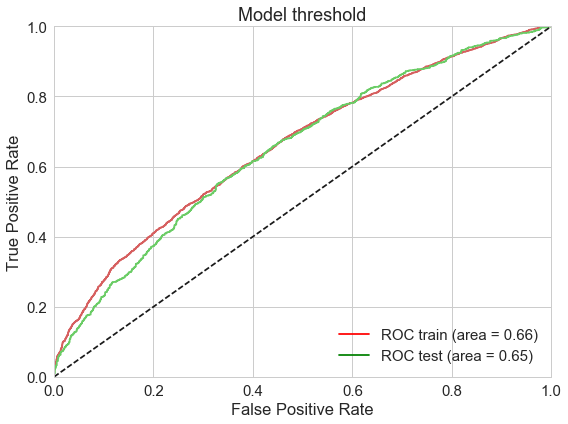

In [196]:
y_prob_train = best_model.predict_proba(X_train_10k)
y_prob_test = best_model.predict_proba(X_test_10k)

fpr_train, tpr_train, _ = metrics.roc_curve(y_train_10k,y_prob_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = metrics.roc_curve(y_test_10k, y_prob_test[:,1])
roc_auc_test = metrics.auc(fpr_test, tpr_test)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color = 'r')
plt.plot(fpr_test, tpr_test, color = 'g')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model threshold')
green_line = mlines.Line2D([], [], color='green', label='ROC test (area = %0.2f)' % np.mean(roc_auc_test))
red_line = mlines.Line2D([], [], color='red', label='ROC train (area = %0.2f)' % roc_auc_train)
plt.legend(handles=[red_line, green_line],loc="lower right")
plt.savefig('roc_first_rf_two_class_few_features.png', dpi = 300)

[[788 445]
 [580 687]]


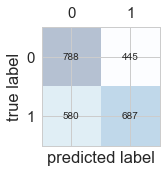

In [186]:
predictions=best_model.predict(X_test_10k)

labels = [0,1] #these are backwards
cm = metrics.confusion_matrix(y_test_10k, predictions)
print(cm)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show()

In [187]:
print "----confusion matrix----"
print metrics.confusion_matrix(y_test_10k, predictions)
print 
print "----classification report----"
print metrics.classification_report(y_test_10k, predictions) 

----confusion matrix----
[[788 445]
 [580 687]]

----classification report----
             precision    recall  f1-score   support

          0       0.58      0.64      0.61      1233
          1       0.61      0.54      0.57      1267

avg / total       0.59      0.59      0.59      2500



/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


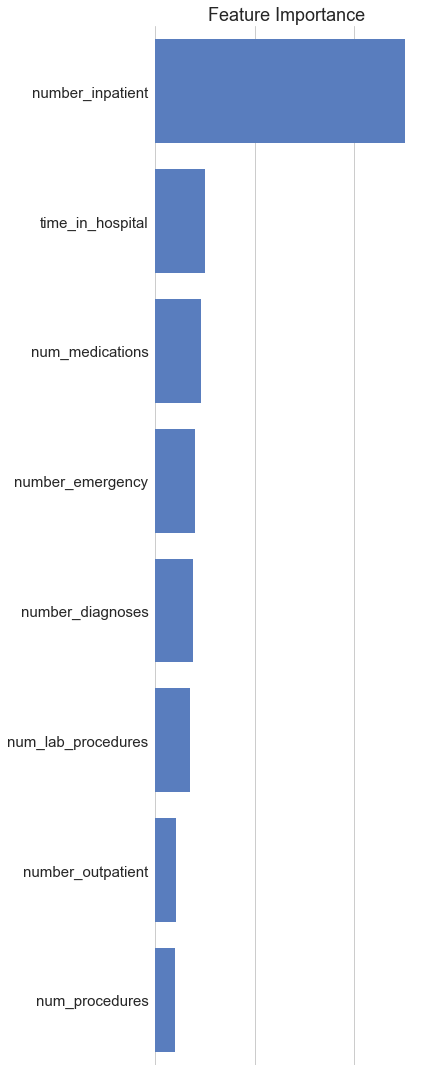

In [188]:
df_importance = pd.DataFrame({'feature': X_train.columns, 'importance' : best_model.feature_importances_})




result = df_importance.sort(['importance'], ascending=False).reset_index()


resultshort = result[:20]

y1= resultshort['feature'][0:]
x1 = resultshort['importance'][0:]

sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(6, 15))
fig = plt.gcf()
plt.tight_layout()
sns.set_color_codes("muted")
sns.barplot(x=x1, y=y1, color="b")
ax.set(xticklabels=[],ylabel='',xlabel='',title='Feature Importance')
sns.despine(left=True, bottom=True)
fig.savefig('randomforest_twoclass_reducedfeatures_importance.png', dpi=300,bbox_inches='tight')

## next brute force random forest, all features, two classes

In [146]:
y = dfdiagdum2['target']

In [147]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_vec,y,test_size=.40)

In [167]:

rf = RandomForestClassifier()


In [168]:
parameters = {'n_estimators': [10,100,500],'max_depth':[5,15,25],'min_samples_leaf':[10,20,50]}
#n_estimators are the number of trees bui

In [169]:
model_cv_grid = grid_search.GridSearchCV(rf,parameters,scoring='roc_auc',verbose=2,n_jobs=-1)


In [151]:
model_cv_grid.fit(X_train,y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  8.3min finished


[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   1.3s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   5.8s



[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............


[CV] ..... n_estimators=500, max_depth=5, min_samples_leaf=10 -  26.7s[CV] ..... n_estimators=500, max_depth=5, min_samples_leaf=10 -  26.3s[CV] ...

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 500], 'max_depth': [5, 15, 25], 'min_samples_leaf': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)





[CV] n_estimators=100, max_depth=25, min_samples_leaf=50 .............
[CV] .... n_estimators=500, max_depth=25, min_samples_leaf=20 - 1.5min[CV] n_estimators=500, max_depth=25, min_samples_leaf=50 .............
[CV] .... n_estimators=100, max_depth=25, min_samples_leaf=50 -  14.5s
[CV] .... n_estimators=500, max_depth=25, min_samples_leaf=50 - 1.0min

[CV] n_estimators=100, max_depth=25, min_samples_leaf=50 .............
[CV] .... n_estimators=100, max_depth=25, min_samples_leaf=50 -  15.0s
[CV] n_estimators=500, max_depth=25, min_samples_leaf=50 .............
[CV] .... n_estimators=500, max_depth=25, min_samples_leaf=50 - 1.0min


In [152]:
best_model = model_cv_grid.best_estimator_

In [153]:
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [154]:
best_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

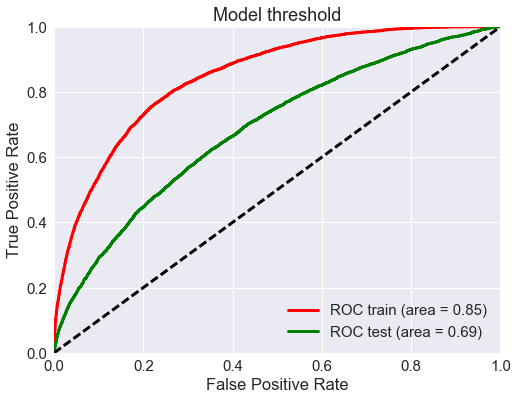

In [52]:
y_prob_train = best_model.predict_proba(X_train)
y_prob_test = best_model.predict_proba(X_test)

fpr_train, tpr_train, _ = metrics.roc_curve(y_train,y_prob_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_prob_test[:,1])
roc_auc_test = metrics.auc(fpr_test, tpr_test)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color = 'r')
plt.plot(fpr_test, tpr_test, color = 'g')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model threshold')
green_line = mlines.Line2D([], [], color='green', label='ROC test (area = %0.2f)' % np.mean(roc_auc_test))
red_line = mlines.Line2D([], [], color='red', label='ROC train (area = %0.2f)' % roc_auc_train)
plt.legend(handles=[red_line, green_line],loc="lower right")
plt.savefig('roc_first_rf_two_class.png', dpi = 300)

## my model is only predicting one class!! just the not readmited class

[[38138     0]
 [ 4902     0]]


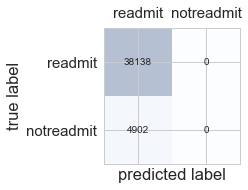

In [57]:
predictions=best_model.predict(X_test)

labels = ['readmit', 'notreadmit'] #these are backwards
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show()
plt.savefig('randomforest_two_class_cm.png', dpi = 300)

In [54]:

y_prob = best_model.predict_proba(X_vec)

dfdiagdum2['score'] = y_prob[:,1]

In [55]:
dfdiagdum2.sort(['score'], ascending = 0).tail()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


encounter_id  patient_nbr             race  gender      age  \
42266      124624812     24016869        Caucasian  Female  [60-70)   
62845      167569692     28945719  AfricanAmerican  Female  [50-60)   
102729     384946310     97719030        Caucasian    Male  [50-60)   
102730     384946310     97719030        Caucasian    Male  [50-60)   
9482        39744420    104934852        Caucasian  Female  [80-90)   

        time_in_hospital payer_code                medical_specialty  \
42266                  2         MC  Surgery-Cardiovascular/Thoracic   
62845                  3       none                             none   
102729                 1         MC                             none   
102730                 1         MC                             none   
9482                   2       none                             none   

        num_lab_procedures  num_procedures  num_medications  \
42266                   51               2               32   
62845                   58               3               27   
102729                  80               3               20   
102730                  80               3               20   
9482                    74               3               13   

        number_outpatient  number_emergency  number_inpatient  \
42266                   0                 0                 0   
62845                   0                 0                 0   
102729                  0                 0                 0   
102730                  0                 0                 0   
9482                    0                 0                 0   

        number_diagnoses max_glu_serum A1Cresult  metformin  glimepiride  \
42266                  9          None      None          0            0   
62845                  9          None      None          0            0   
102729                12          None      None          0            0   
102730                12          None      None          0            0   
9482                   9          None      None          0            0   

        glipizide  glyburide  pioglitazone  rosiglitazone  insulin change  \
42266           0          0             0              0        1     No   
62845           0          0             0              0        1     No   
102729          0          0             0              0        1     No   
102730          0          0             0              0        1     No   
9482            0          0             0              0        1     No   

       diabetesMed readmitted admission_type_desc discharge_disposition_desc  \
42266          Yes         NO           Emergency                    Expired   
62845          Yes         NO           Emergency                    Expired   
102729         Yes         NO           Emergency                    Expired   
102730         Yes         NO           Emergency                    Expired   
9482           Yes         NO           Emergency                    Expired   

       admission_source_desc  cleaned_age  target  \
42266         Emergency Room            6       0   
62845        Clinic Referral            5       0   
102729        Emergency Room            5       0   
102730        Emergency Room            5       0   
9482          Emergency Room            8       0   

        Acute Myocardial Infarction  Acute Renal Failure  \
42266                           0.0                  0.0   
62845                           0.0                  0.0   
102729                          0.0                  0.0   
102730                          0.0                  0.0   
9482                            0.0                  1.0   

        Amputation Status, Lower Limb/Amputation Complications  \
42266                                                 0.0        
62845                                                 0.0        
102729                                                0.0        
102730                           

## intiutively the features that are most important make sense, especially the number of inpatient visits in the year preceding the encounter

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


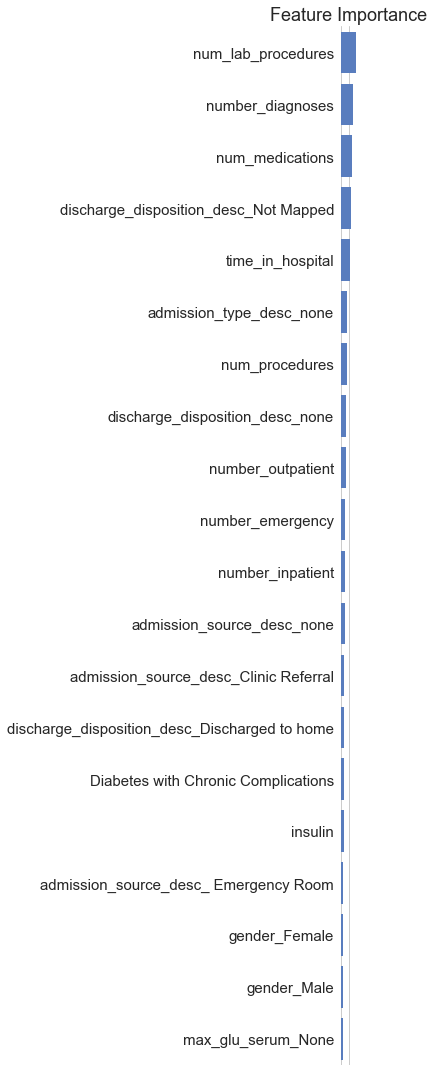

In [155]:
df_importance = pd.DataFrame({'feature': X_train.columns, 'importance' : best_model.feature_importances_})




result = df_importance.sort(['importance'], ascending=False).reset_index()


resultshort = result[:20]

y1= resultshort['feature'][0:]
x1 = resultshort['importance'][0:]

sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(6, 15))
fig = plt.gcf()
plt.tight_layout()
sns.set_color_codes("muted")
sns.barplot(x=x1, y=y1, color="b")
ax.set(xticklabels=[],ylabel='',xlabel='',title='Feature Importance')
sns.despine(left=True, bottom=True)
fig.savefig('randomforest_twoclass_feature_importance.png', dpi=300,bbox_inches='tight')

In [58]:
result.tail() #many features appear not to be important

index                                            feature  importance
152    132  discharge_disposition_desc_Expired in a medica...         0.0
153    131  discharge_disposition_desc_Expired at home. Me...         0.0
154    114  discharge_disposition_desc_Admitted as an inpa...         0.0
155     22  Atherosclerosis of the Extremities with Ulcera...         0.0
156    129  discharge_disposition_desc_Discharged/transfer...         0.0

In [59]:
predictions=best_model.predict(X_test)
sklearn.metrics.accuracy_score(y_test, predictions)


0.88610594795539033

## model is not detecting any readmitted class!!! and of course it has high precision and recall for the other class because it just labels all as class 0!

In [60]:
print "----confusion matrix----"
print metrics.confusion_matrix(y_test, predictions)
print 
print "----classification report----"
print metrics.classification_report(y_test, predictions)  

----confusion matrix----
[[38138     0]
 [ 4902     0]]

----classification report----
             precision    recall  f1-score   support

          0       0.89      1.00      0.94     38138
          1       0.00      0.00      0.00      4902

avg / total       0.79      0.89      0.83     43040



/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## this is not predicting my readmitted class!!!

In [61]:
y_prob_test = best_model.predict_proba(X_test)
precision_val, recall_val, thresholds_val = metrics.precision_recall_curve(y_test,y_prob_test[:,1])

In [62]:
thresholds_val = np.append(thresholds_val, 1)
queue_rate_val = []  
for threshold in thresholds_val:  
    queue_rate_val.append((y_prob_test[:,1] >= threshold).mean())

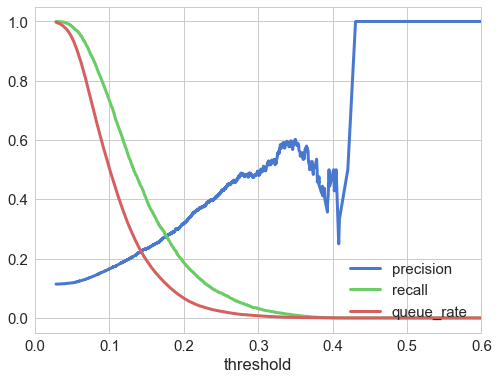

In [63]:

plt.figure(figsize=(8,6))
plt.plot(thresholds_val, precision_val, color = 'b', linewidth=3.0)  
plt.plot(thresholds_val, recall_val, color = 'g', linewidth=3.0)  
plt.plot(thresholds_val, queue_rate_val, color = 'r', linewidth=3.0)
leg = plt.legend(('precision', 'recall', 'queue_rate'),loc="lower right")
plt.xlabel('threshold')
plt.xlim([0.0, 0.6])
# at a certain threshold this does terribly, perhaps because it is acurately predicting the not readmitted class but then fails
#completely for all readmitted
plt.savefig('rf_two_class_precision_recall.png', dpi = 300)

In [64]:
dfdiagdum2['predictions'] = best_model.predict(X_vec)

In [65]:
dfdiagdum2.predictions.unique() #looks like it's only predicting one class!!!!!

array([0])

## This looks very bad...seems like my model is only predicting one class ? :( try two things, predicting on three classes and make classes of readmitted and not more equal for training purposes

In [407]:
#try with three classes
len(dfdiagdum2[dfdiagdum2['target2']==1]), len(dfdiagdum2[dfdiagdum2['target2']==0]), len(dfdiagdum2[dfdiagdum2['target2']==2])

(12133, 57921, 37546)

In [26]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle #having trouble importing the multioutputclassifier module

In [27]:
from sklearn import svm
#traditionally handles multi class but takes standardized inputs

## here taking equal subsample of two classes

In [133]:
#i want to use svm.svc but i am having trouble importing the library
#try a subsample of the three classes that has equal proportions
#randomly sampe 5000 from each class

num = 5000 #number of samples
sub_ind_readmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='<30'].index),num)
sub_ind_notreadmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted'].isin(['NO','>30'])].index),num)

In [134]:
subindex = []
for i in sub_ind_readmit:
    subindex.append(i)
for i in sub_ind_notreadmit:
    subindex.append(i)

In [135]:
len(set(subindex))

10000

In [136]:
#use a subset of the data to train because it takes a while, take a sample of 10000

X_vec_10k = X_vec.loc[subindex]
y = dfdiagdum2['target']
y_10k = y.loc[subindex]

In [137]:
#split into test train and  standardize
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_10k, X_test_10k, y_train_10k, y_test_10k = cross_validation.train_test_split(X_vec_10k,y_10k)
X_train_norm = stdsc.fit_transform(X_train_10k)
X_test_norm = stdsc.transform(X_test_10k)

## redo and train and test on subset of the data equally represeting both classes

In [138]:
X_train_10k, X_test_10k, y_train_10k, y_test_10k = cross_validation.train_test_split(X_vec_10k,y_10k)

In [139]:

rf = RandomForestClassifier()
parameters = {'n_estimators': [10,100,500],'max_depth':[5,15,25],'min_samples_leaf':[10,20,50]}
model_cv_grid = grid_search.GridSearchCV(rf,parameters,scoring='roc_auc',verbose=2,n_jobs=-1)
model_cv_grid.fit(X_train_10k,y_train_10k)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.1min finished


[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.2s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.2s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.2s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.2s



[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ...

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 500], 'max_depth': [5, 15, 25], 'min_samples_leaf': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [140]:
best_model = model_cv_grid.best_estimator_

In [141]:

best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [142]:
best_model.fit(X_train_10k,y_train_10k)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [143]:
#what if we use the model on the full training dataset?
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_vec,y,test_size=.40)
best_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

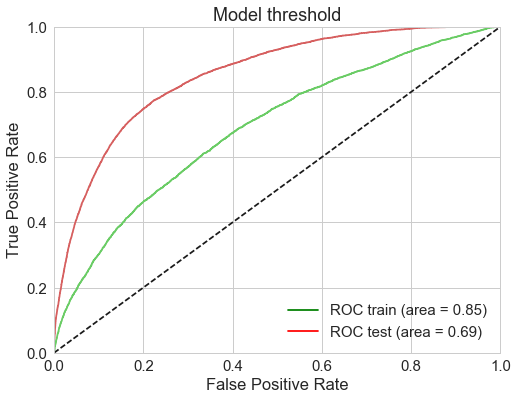

In [77]:
y_prob_train_tuned = best_model.predict_proba(X_train)
y_prob_test_tuned = best_model.predict_proba(X_test)
fpr_train_tuned, tpr_train_tuned, _ = metrics.roc_curve(y_train,y_prob_train_tuned[:,1])
roc_auc_train_tuned = metrics.auc(fpr_train_tuned, tpr_train_tuned)
fpr_test_tuned, tpr_test_tuned, _ = metrics.roc_curve(y_test,y_prob_test_tuned[:,1])
roc_auc_test_tuned = metrics.auc(fpr_test_tuned, tpr_test_tuned)
plt.figure(figsize=(8,6))
plt.plot(fpr_train_tuned, tpr_train_tuned, color = 'r')
plt.plot(fpr_test_tuned, tpr_test_tuned, color = 'g')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model threshold')
green_line = mlines.Line2D([], [], color='green', label='ROC train (area = %0.2f)' % np.mean(roc_auc_train_tuned))
red_line = mlines.Line2D([], [], color='red', label='ROC test (area = %0.2f)' % roc_auc_test_tuned)
plt.legend(handles=[green_line, red_line],loc="lower right")
plt.savefig('roc_rf_equal_two_class.png', dpi = 300)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


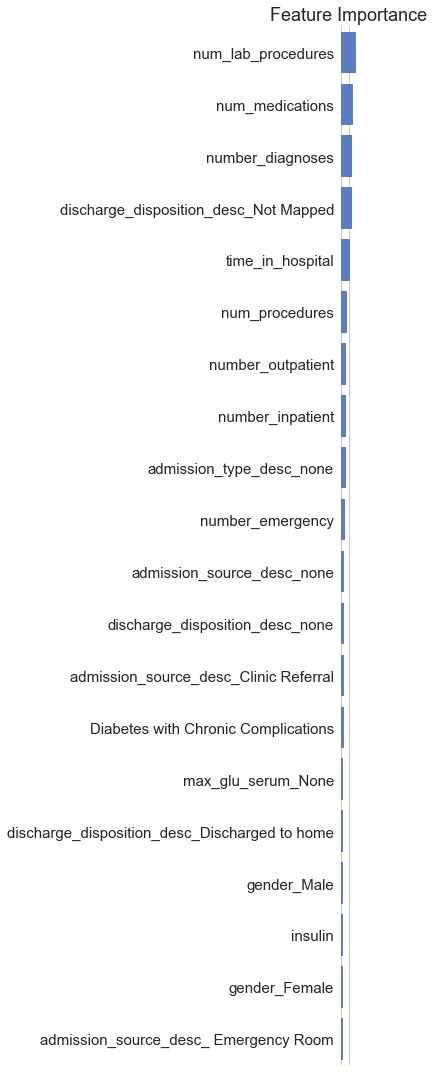

In [144]:
df_importance = pd.DataFrame({'feature': X_train.columns, 'importance' : best_model.feature_importances_})




result = df_importance.sort(['importance'], ascending=False).reset_index()


resultshort = result[:20]

y1= resultshort['feature'][0:]
x1 = resultshort['importance'][0:]

sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(6, 15))
fig = plt.gcf()
plt.tight_layout()
sns.set_color_codes("muted")
sns.barplot(x=x1, y=y1, color="b")
ax.set(xticklabels=[],ylabel='',xlabel='',title='Feature Importance')
sns.despine(left=True, bottom=True)
fig.savefig('randomforest_twoclass_feature_importance_equalclass.png', dpi=300,bbox_inches='tight')

In [78]:
#looks like it does so, so, does it predict two classes???
dfdiagdum2['predictions2'] = best_model.predict(X_vec)

In [79]:
dfdiagdum2.predictions2.unique() #NOOOOO WHY?

array([0])

In [81]:
predictions=best_model.predict(X_test_10k)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test_10k, predictions)
print 
print "----classification report----"
print metrics.classification_report(y_test_10k, predictions)  

----confusion matrix----
[[1288    0]
 [1212    0]]

----classification report----
             precision    recall  f1-score   support

          0       0.52      1.00      0.68      1288
          1       0.00      0.00      0.00      1212

avg / total       0.27      0.52      0.35      2500



In [82]:
y_prob = best_model.predict_proba(X_vec)

dfdiagdum2['score2'] = y_prob[:,1]

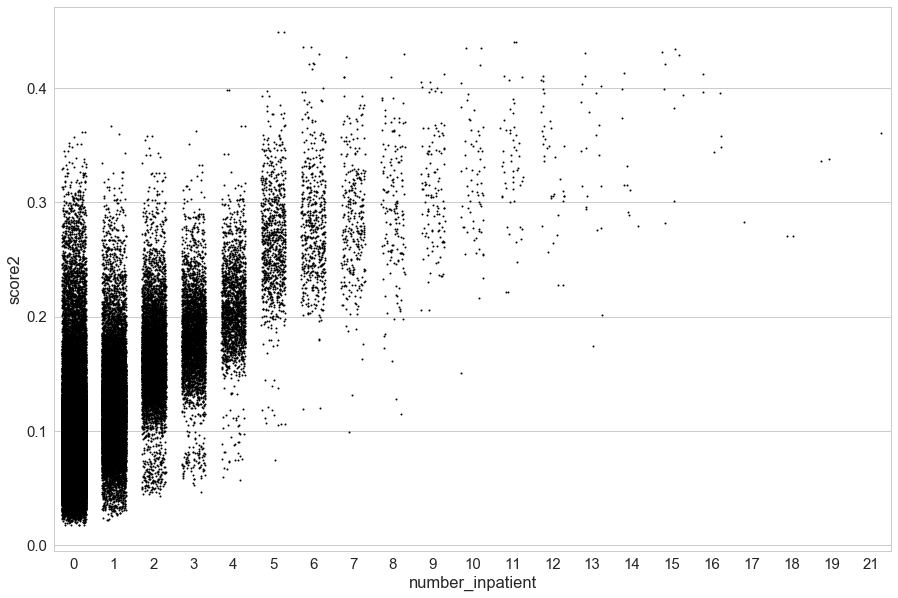

In [83]:

plt.figure(figsize=(15, 10))


sns.stripplot(x="number_inpatient", y="score2"
                    ,data=dfdiagdum2.sort_values(by="number_inpatient")
                    ,orient='v',jitter=0.3, size=1
                    , color="0.1",edgecolor="black")
plt.savefig('rf_score_number_inpatient.png', dpi = 300)

## there is a major issue with the random forest. it is only predicting one class, the non-readmitted class.  THREE CLASS RANDOM FOREST

In [201]:
#multi class random forest
from sklearn.preprocessing import MultiLabelBinarizer


In [202]:
num = 5000 #number of samples  per category
sub_ind_readmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='<30'].index),num)
sub_ind_notreadmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='NO'].index),num)
sub_ind_over30 = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='>30'].index),num)


In [203]:
subindex = []
for i in sub_ind_readmit:
    subindex.append(i)
for i in sub_ind_notreadmit:
    subindex.append(i)
for i in sub_ind_over30:
    subindex.append(i)

In [204]:
X_vec_10k = X_vec.loc[subindex]
y = dfdiagdum2['target2']
y_10k = y.loc[subindex]

In [219]:
targetlist = dfdiagdum2['target2'].loc[subindex].tolist()

In [228]:
targetstring = []
for i in dfdiagdum2['target2'].loc[subindex]:
    i = str(i)
    targetstring.append(i)

In [230]:
ymulti = MultiLabelBinarizer().fit_transform(targetstring)

In [231]:
n_samples, n_features = X_vec_10k.shape 
n_outputs = ymulti.shape[1] 
n_classes = 3

In [233]:
forest = RandomForestClassifier(n_estimators=100, random_state=1)

In [234]:
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

In [235]:
multi_target_forest.fit(X_vec_10k,ymulti)

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
           n_jobs=-1)

In [237]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_vec_10k,ymulti,test_size=.40)


In [238]:
multi_target_forest.fit(X_train,y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
           n_jobs=-1)

In [242]:
predictions=multi_target_forest.predict(X_test)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test, predictions)
print 
print "----classification report----"
print metrics.classification_report(y_test, predictions) 

----confusion matrix----


ValueError: multilabel-indicator is not supported

In [243]:
multi_target_forest.predict(X_vec)

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ..., 
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [244]:
#try regular random forest
rf = RandomForestClassifier()
parameters = {'n_estimators': [10,100,500],'max_depth':[5,15,25],'min_samples_leaf':[10,20,50]}
model_cv_grid = grid_search.GridSearchCV(rf,parameters,scoring='roc_auc',verbose=2,n_jobs=-1)
model_cv_grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.1min finished


[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.3s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.3s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.2s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.4s



[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ...

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 500], 'max_depth': [5, 15, 25], 'min_samples_leaf': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [245]:
best_model = model_cv_grid.best_estimator_
best_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


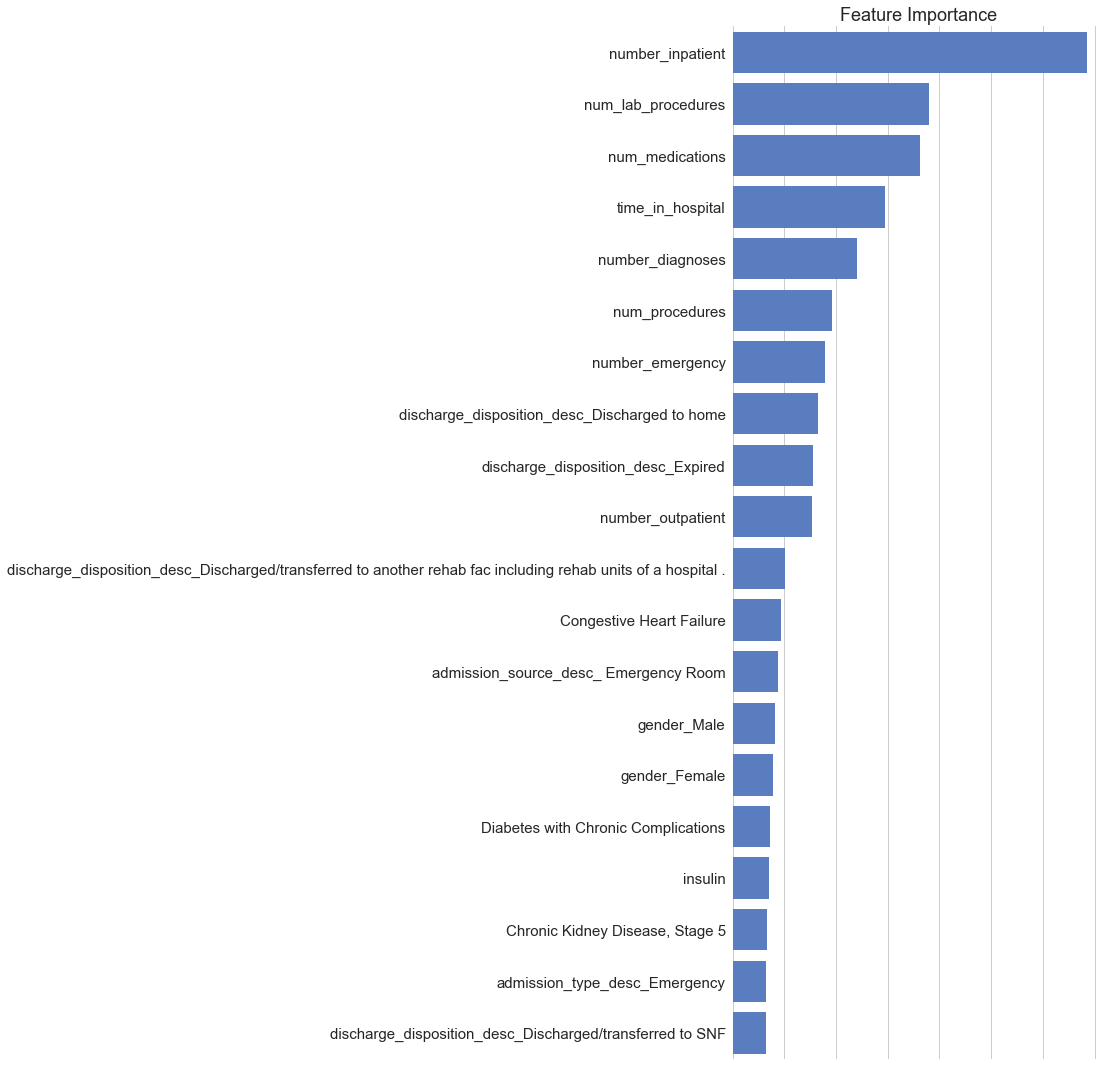

In [247]:
df_importance = pd.DataFrame({'feature': X_train.columns, 'importance' : best_model.feature_importances_})




result = df_importance.sort(['importance'], ascending=False).reset_index()


resultshort = result[:20]

y1= resultshort['feature'][0:]
x1 = resultshort['importance'][0:]

sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(6, 15))
fig = plt.gcf()
plt.tight_layout()
sns.set_color_codes("muted")
sns.barplot(x=x1, y=y1, color="b")
ax.set(xticklabels=[],ylabel='',xlabel='',title='Feature Importance')
sns.despine(left=True, bottom=True)
fig.savefig('randomforest_threeclass_feature_importance_equalclass.png', dpi=300,bbox_inches='tight')

In [255]:
multipred = best_model.predict(X_vec)

In [256]:
dftarget = pd.DataFrame(multipred)

In [265]:
dftarget.columns = [['NO','under_30','over_30']] #0 is no, 1 is <30, 2 is >30

In [266]:
dftarget['NO'].unique() #order was lost so can not rejoin back to original

array([ 0.,  1.])

## redo and try with logistic regression. this means do standard scaling.


## can try a few things. first just train/testing on my original split data. can also train/test on the subset of data with equal classes. also i am scaling everything but should perhaps try only scaling the numeric and joining back to the dummy variable columns

In [84]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

X_train_norm = stdsc.fit_transform(X_train_10k)
X_test_norm = stdsc.transform(X_test_10k)


In [85]:
from sklearn import svm, metrics, grid_search, linear_model, datasets
from sklearn.linear_model import LogisticRegression
cls = linear_model.LogisticRegression()


In [86]:
#the grid search automatically includes l1 and l2 and it will find the best one!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gslr = grid_search.GridSearchCV(cls, 
                                param_grid= {'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
                               ).fit(X_train_norm, y_train_10k)

In [87]:
print 'Best score:', gslr.best_score_ 
print 'Best estimator:', gslr.best_estimator_

Best score: 0.61
Best estimator: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [88]:
gslr_best = gslr.best_estimator_

In [114]:
gslr_best.fit(X_train_10k,y_train_10k)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [115]:
x_pred_test = gslr_best.predict(X_test_norm)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test_10k, x_pred_test)
print 
print "----classification report----"
print metrics.classification_report(y_test_10k, x_pred_test) 

----confusion matrix----
[[946 342]
 [717 495]]

----classification report----
             precision    recall  f1-score   support

          0       0.57      0.73      0.64      1288
          1       0.59      0.41      0.48      1212

avg / total       0.58      0.58      0.56      2500



[[946 342]
 [717 495]]


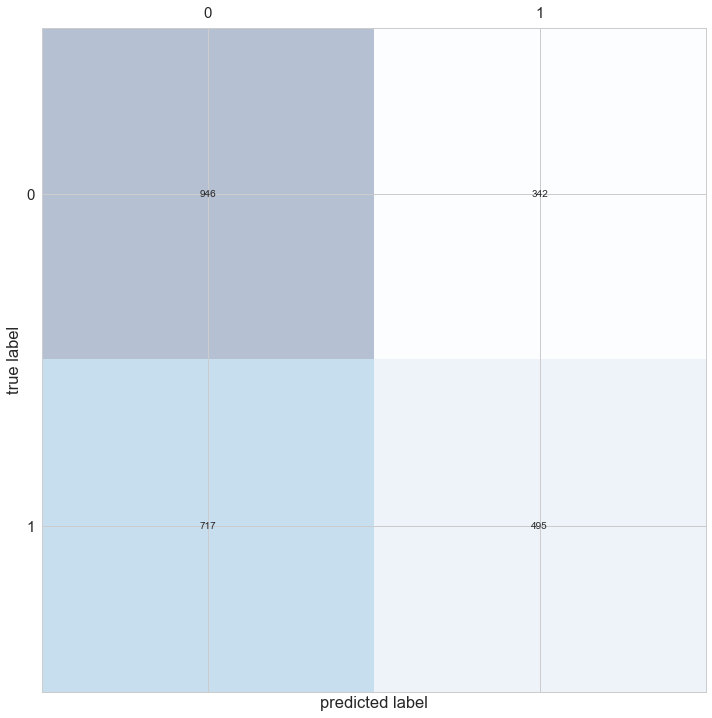

In [116]:
labels = [0,1]
cm = metrics.confusion_matrix(y_test_10k, x_pred_test)
print(cm)
fig, ax = plt.subplots(figsize=(10,20))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show() #does butter than chance but not great
plt.savefig('logistic_regression_cm_twoclass.png', dpi = 300)

In [92]:
y_prob_train = gslr_best.predict_proba(X_train_norm)
y_prob_test = gslr_best.predict_proba(X_test_norm)
fpr_train, tpr_train, _ = metrics.roc_curve(y_train_10k,y_prob_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test_10k, y_prob_test[:,1])
roc_auc_test = metrics.auc(fpr_test, tpr_test)


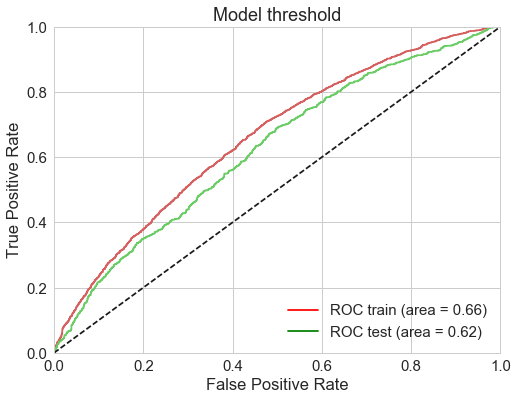

In [93]:
plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color = 'r')
plt.plot(fpr_test, tpr_test, color = 'g')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model threshold')
green_line = mlines.Line2D([], [], color='green', label='ROC test (area = %0.2f)' % np.mean(roc_auc_test))

red_line = mlines.Line2D([], [], color='red', label='ROC train (area = %0.2f)' % roc_auc_train)
plt.legend(handles=[red_line, green_line],loc="lower right")
plt.savefig('roc_lg_twoclass.png', dpi = 300)

In [159]:
#look at feature importance

df_importance = pd.DataFrame({'variable': X_vec.columns, 'importance' : gslr_best.coef_[0]})
result = df_importance.sort(['importance'], ascending=False).reset_index()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

resultshort = result[:20]
y1= resultshort['variable'][0:]
x1 = resultshort['importance'][0:]
sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(6, 15))
fig = plt.gcf()

sns.set_color_codes("muted")
sns.barplot(x=x1, y=y1, color="b")
ax.set(xticklabels=[],ylabel='',xlabel='',title='Feature Importance')
sns.despine(left=True, bottom=True)
plt.savefig('lg_feature_importance_twoclass.png', dpi = 300, box = )

SyntaxError: invalid syntax (<ipython-input-159-220d0b00e067>, line 19)

In [95]:
#how about on the full training data?

X_train_norm_full = stdsc.fit_transform(X_train)
X_test_norm_full = stdsc.transform(X_test)


In [96]:
gslr_best.fit(X_train_norm_full,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
y_prob_train_tuned = gslr_best.predict_proba(X_train_norm_full)
y_prob_test_tuned = gslr_best.predict_proba(X_test_norm_full)


In [98]:
fpr_train_tuned, tpr_train_tuned, _ = metrics.roc_curve(y_train,y_prob_train_tuned[:,1])
roc_auc_train_tuned = metrics.auc(fpr_train_tuned, tpr_train_tuned)
fpr_test_tuned, tpr_test_tuned, _ = metrics.roc_curve(y_test,y_prob_test_tuned[:,1])
roc_auc_test_tuned = metrics.auc(fpr_test_tuned, tpr_test_tuned)

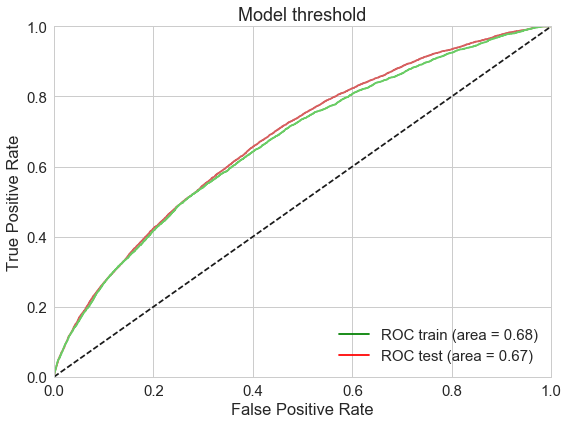

In [99]:
plt.figure(figsize=(8,6))
plt.plot(fpr_train_tuned, tpr_train_tuned, color = 'r')
plt.plot(fpr_test_tuned, tpr_test_tuned, color = 'g')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model threshold')
green_line = mlines.Line2D([], [], color='green', label='ROC train (area = %0.2f)' % np.mean(roc_auc_train_tuned))
red_line = mlines.Line2D([], [], color='red', label='ROC test (area = %0.2f)' % roc_auc_test_tuned)
plt.legend(handles=[green_line, red_line],loc="lower right")
plt.savefig('lg_roc_fulldata_twoclass.png', dpi = 300)

In [160]:
#look at feature importance

df_importance = pd.DataFrame({'variable': X_vec.columns, 'importance' : gslr_best.coef_[0]})

In [161]:
result = df_importance.sort(['importance'], ascending=False).reset_index()


resultshort = result[:20]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


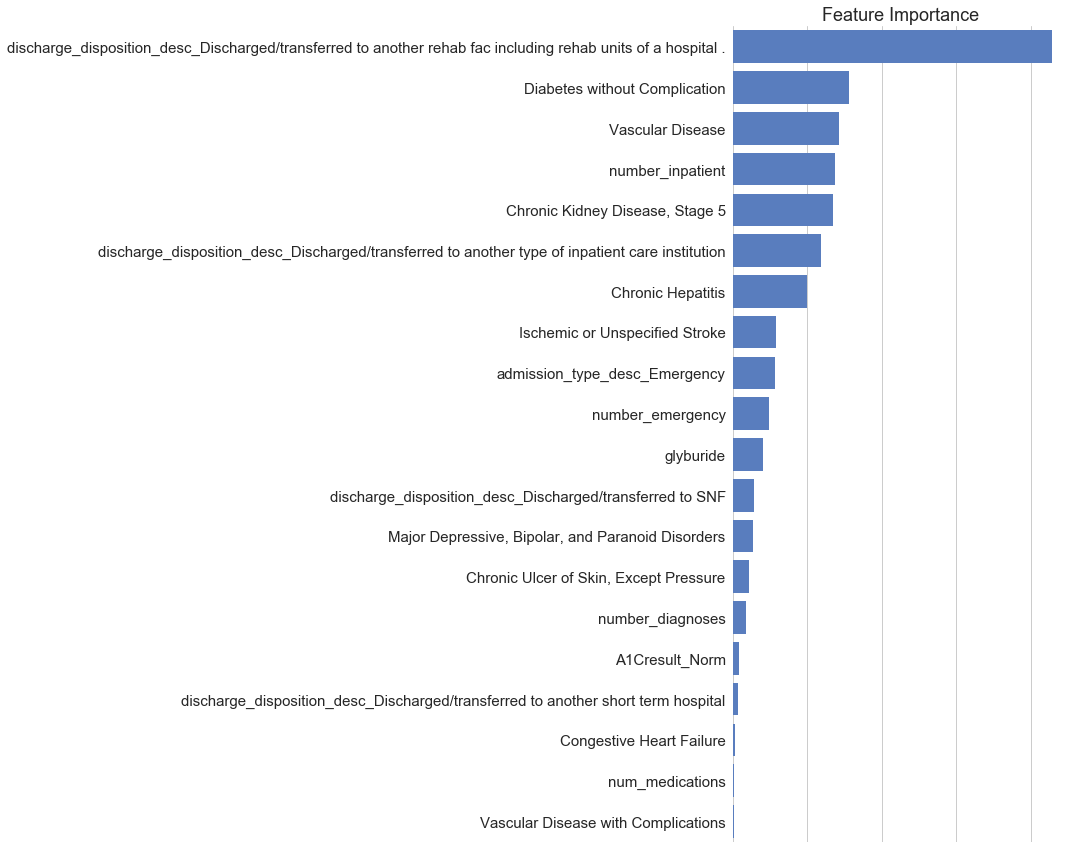

In [162]:
y1= resultshort['variable'][0:]
x1 = resultshort['importance'][0:]
sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(6, 15))
fig = plt.gcf()
sns.set_color_codes("muted")
sns.barplot(x=x1, y=y1, color="b")
ax.set(xticklabels=[],ylabel='',xlabel='',title='Feature Importance')
sns.despine(left=True, bottom=True)


fig.savefig('lg_twoclass_feature_importance_fulldata.png', dpi=300,bbox_inches='tight')

In [103]:
x_pred_test = gslr_best.predict(X_test_norm_full)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test, x_pred_test)
print 
print "----classification report----"
print metrics.classification_report(y_test, x_pred_test) 

----confusion matrix----
[[38044    93]
 [ 4811    92]]

----classification report----
             precision    recall  f1-score   support

          0       0.89      1.00      0.94     38137
          1       0.50      0.02      0.04      4903

avg / total       0.84      0.89      0.84     43040



[[38044    93]
 [ 4811    92]]


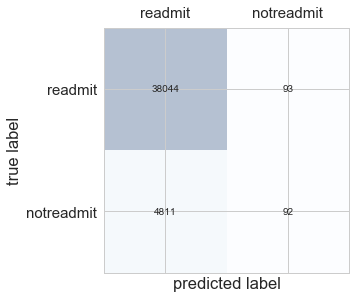

In [104]:
labels = ['readmit', 'notreadmit']
cm = metrics.confusion_matrix(y_test, x_pred_test)
print(cm)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show() #now mislabeling a lot of notreadmitted patients as readmit
plt.savefig('lg_cm_twoclass.png', dpi = 300)

In [105]:
#now fit on all the data
allx_norm = stdsc.transform(X_vec)



In [106]:
gslr_best.fit(allx_norm, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [107]:
y_prob =gslr_best.predict_proba(allx_norm)

In [108]:
dfdiagdum2['lg_score3'] = y_prob[:,1]

In [109]:
dfdiagdum2 = dfdiagdum2.sort(['lg_score3'],ascending = 0)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [117]:
dfdiagdum2[['target','lg_score3']].head()

target  lg_score3
65317       0   0.968384
34370       1   0.955819
62869       1   0.946867
80751       1   0.912368
92079       0   0.896863

In [118]:
num = 5000 #number of samples  per category
sub_ind_readmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='<30'].index),num)
sub_ind_notreadmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='NO'].index),num)
sub_ind_over30 = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='>30'].index),num)

subindex = []
for i in sub_ind_readmit:
    subindex.append(i)
for i in sub_ind_notreadmit:
    subindex.append(i)
for i in sub_ind_over30:
    subindex.append(i)

In [119]:
X_vec_10k = X_vec.loc[subindex]
y = dfdiagdum2['target2']
y_10k = y.loc[subindex]

#split into test train and  standardize
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_10k, X_test_10k, y_train_10k, y_test_10k = cross_validation.train_test_split(X_vec_10k,y_10k)
X_train_norm = stdsc.fit_transform(X_train_10k)
X_test_norm = stdsc.transform(X_test_10k)

In [120]:
n_samples, n_features = X_train_norm.shape 
n_classes = 3

In [121]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import numpy as np

In [122]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [123]:
clf = svm.SVC()
clf.fit(X_train_norm, y_train_10k) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

[[693 211 342]
 [348 484 443]
 [389 297 543]]


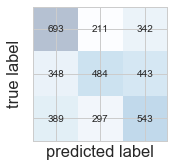

In [124]:
predictions=clf.predict(X_test_norm)


cm = metrics.confusion_matrix(y_test_10k, predictions)
print(cm)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] )
ax.set_yticklabels([''] )
plt.show()
plt.savefig('svc_first.png', dpi = 300)

In [125]:
#try one versus one and one versus rest
clf = svm.SVC(decision_function_shape='ovo') #one versus one
clf.fit(X_train_norm, y_train_10k) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

[[693 211 342]
 [348 484 443]
 [389 297 543]]


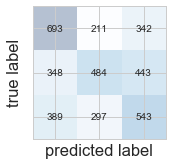

In [126]:
predictions=clf.predict(X_test_norm)


cm = metrics.confusion_matrix(y_test_10k, predictions)
print(cm)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] )
ax.set_yticklabels([''] )
plt.savefig('svm_ovo.png', dpi = 300)

In [130]:
predictions=clf.predict(X_test_norm)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test_10k, predictions)
print 
print "----classification report----"
print metrics.classification_report(y_test_10k, predictions) 

----confusion matrix----
[[693 211 342]
 [348 484 443]
 [389 297 543]]

----classification report----
             precision    recall  f1-score   support

          0       0.48      0.56      0.52      1246
          1       0.49      0.38      0.43      1275
          2       0.41      0.44      0.42      1229

avg / total       0.46      0.46      0.46      3750



In [127]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train_norm, y_train_10k) #one versus rest

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

[[695 236 315]
 [353 505 417]
 [415 327 487]]


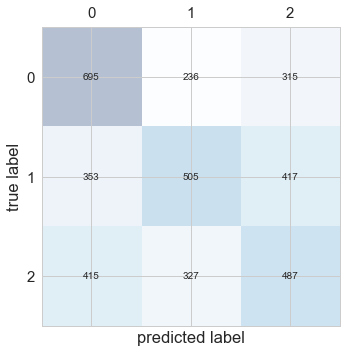

In [128]:
predictions=lin_clf.predict(X_test_norm)

labels = [0,1,2]
cm = metrics.confusion_matrix(y_test_10k, predictions)
print(cm)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] + labels )
ax.set_yticklabels([''] + labels)
fig.savefig('linclf_svm_cm.png', index = False, dpi = 300)

In [129]:
predictions=lin_clf.predict(X_test_norm)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test_10k, predictions)
print 
print "----classification report----"
print metrics.classification_report(y_test_10k, predictions) 

----confusion matrix----
[[695 236 315]
 [353 505 417]
 [415 327 487]]

----classification report----
             precision    recall  f1-score   support

          0       0.48      0.56      0.51      1246
          1       0.47      0.40      0.43      1275
          2       0.40      0.40      0.40      1229

avg / total       0.45      0.45      0.45      3750



In [117]:
predictions=lin_clf.predict(allx_norm)

In [119]:
predictions

array([0, 2, 2, ..., 1, 1, 0], dtype=int64)

In [120]:
dfdiagdum2['linclfpred'] = predictions

In [122]:
dfdiagdum2[['target2', 'linclfpred']].head() #its not great...

target2  linclfpred
0        0           0
1        2           2
2        0           2
3        0           2
4        0           1

## If I had more time I would do more basic analysis: which classes are acutally more similar ie. do readmission within 30 days and readmission > 30 days look more similar then not readmitted? Perhaps I grouped them incorrectly in my two class model. Try removing features: perhaps I am using too many features that just aren't very different across classes such as many of the drugs. Do simple statistical tests like ANOVA to test if certain features vary significantly across classes. Try dimensionality reduction. Try three classes with random forest and work more on parameter exploration in 3 class svm.